#**HOME CREDIT SCORE CARD MODEL**

**Background**

The difficulty of getting a loan due to sufficient credit history makes it difficult for many people to get a loan. Home Credit Indonesia wants to predict a client's credit repayment ability using a machine learning (ML) model. Using existing data, Home Credit Indonesia wants to know the criteria for customers who have no problem in the credit process that will help clients succeed in running their bussiness and also help increase their income.

**Step:**

1. Data Cleaning
2. Data Visualization
3. Build ML models
4. Predict client's repayment abilities
5. Provide recommendation for the company

In [ ]:
#IMPORT LIBRARY
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_auc_score

In [ ]:
#LOAD DATASET
df_train = pd.read_csv('application_train.csv', sep=',')
print('Rows = %d \nColumn = %d\n' % df_train.shape)
df_train.head()

Rows = 307511 
Column = 122



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The TARGET feature indicates client's financial condition wheter or not the client has financial difficulties. Means they had late payment more than X days at least one of the first y installments of the loan. Such case is marked as 1 while other all other case as 0.

### **Exploratory Data Analysis (EDA)**

In [ ]:
#CHECK DATA TYPES
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

#### **Data Visualization**

#####**Univariate: The Number of Customers Based on Their Repayment Abilities**

In [ ]:
train = df_train.copy()

decode_map = {0: "No Payment Difficulties", 1: "Payment Difficulties"}
def decode_sentiment(label):
    return decode_map[int(label)]

train['TARGET'] = train['TARGET'].apply(lambda x: decode_sentiment(x))

target_grp = (train[['TARGET']]
                .groupby("TARGET")
                .agg(COUNT=("TARGET","count"))
                .sort_values(by=["COUNT"],ascending=False)
                .reset_index()
                )

target_grp.style.background_gradient(cmap='Blues')

,TARGET,COUNT
0,No Payment Difficulties,282686
1,Payment Difficulties,24825


In [ ]:
grp = train['TARGET'].value_counts(normalize=True)
grp.reset_index().style.background_gradient(cmap='Blues')

,index,TARGET
0,No Payment Difficulties,0.919271
1,Payment Difficulties,0.080729


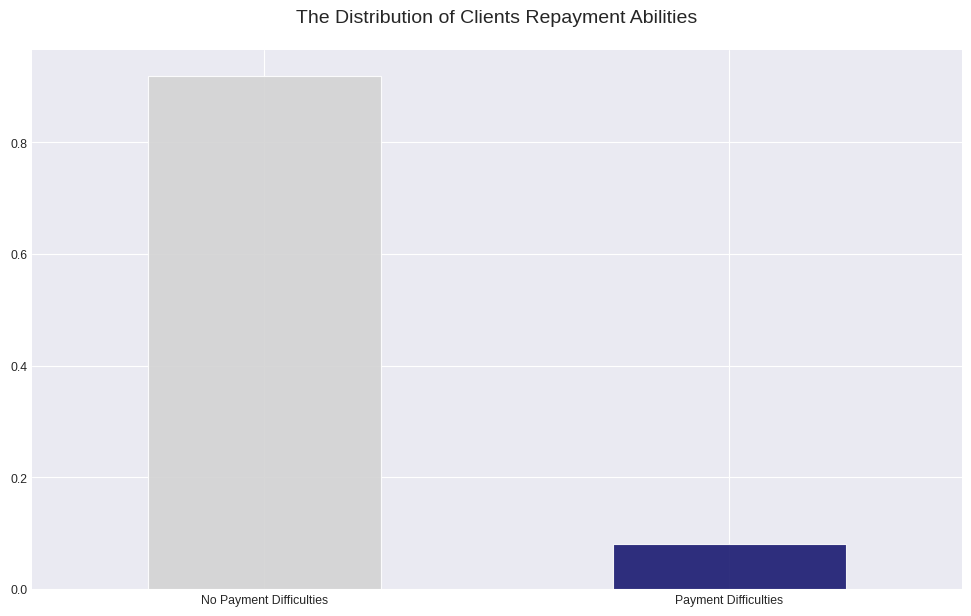

In [ ]:
fig = plt.figure(figsize = (12,7))
grp.plot(kind='bar', color= ['lightgrey','midnightblue'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.show()

About 91% loans (±282.000) with TARGET=0 did not had any problems in repaying the loan in giving time. Only 9% of the total loans (±24.000) in this dataset having problems in repaying the loan.

#####**Bivariate: Categorical Features vs Target**

**1. Contract Type, Gender, Car Ownership Status, and Realty Ownership Status**

<Axes: title={'center': '\nClients Repayment Abilities By Realty Ownership Status\n'}, xlabel='FLAG_OWN_REALTY', ylabel='count'>

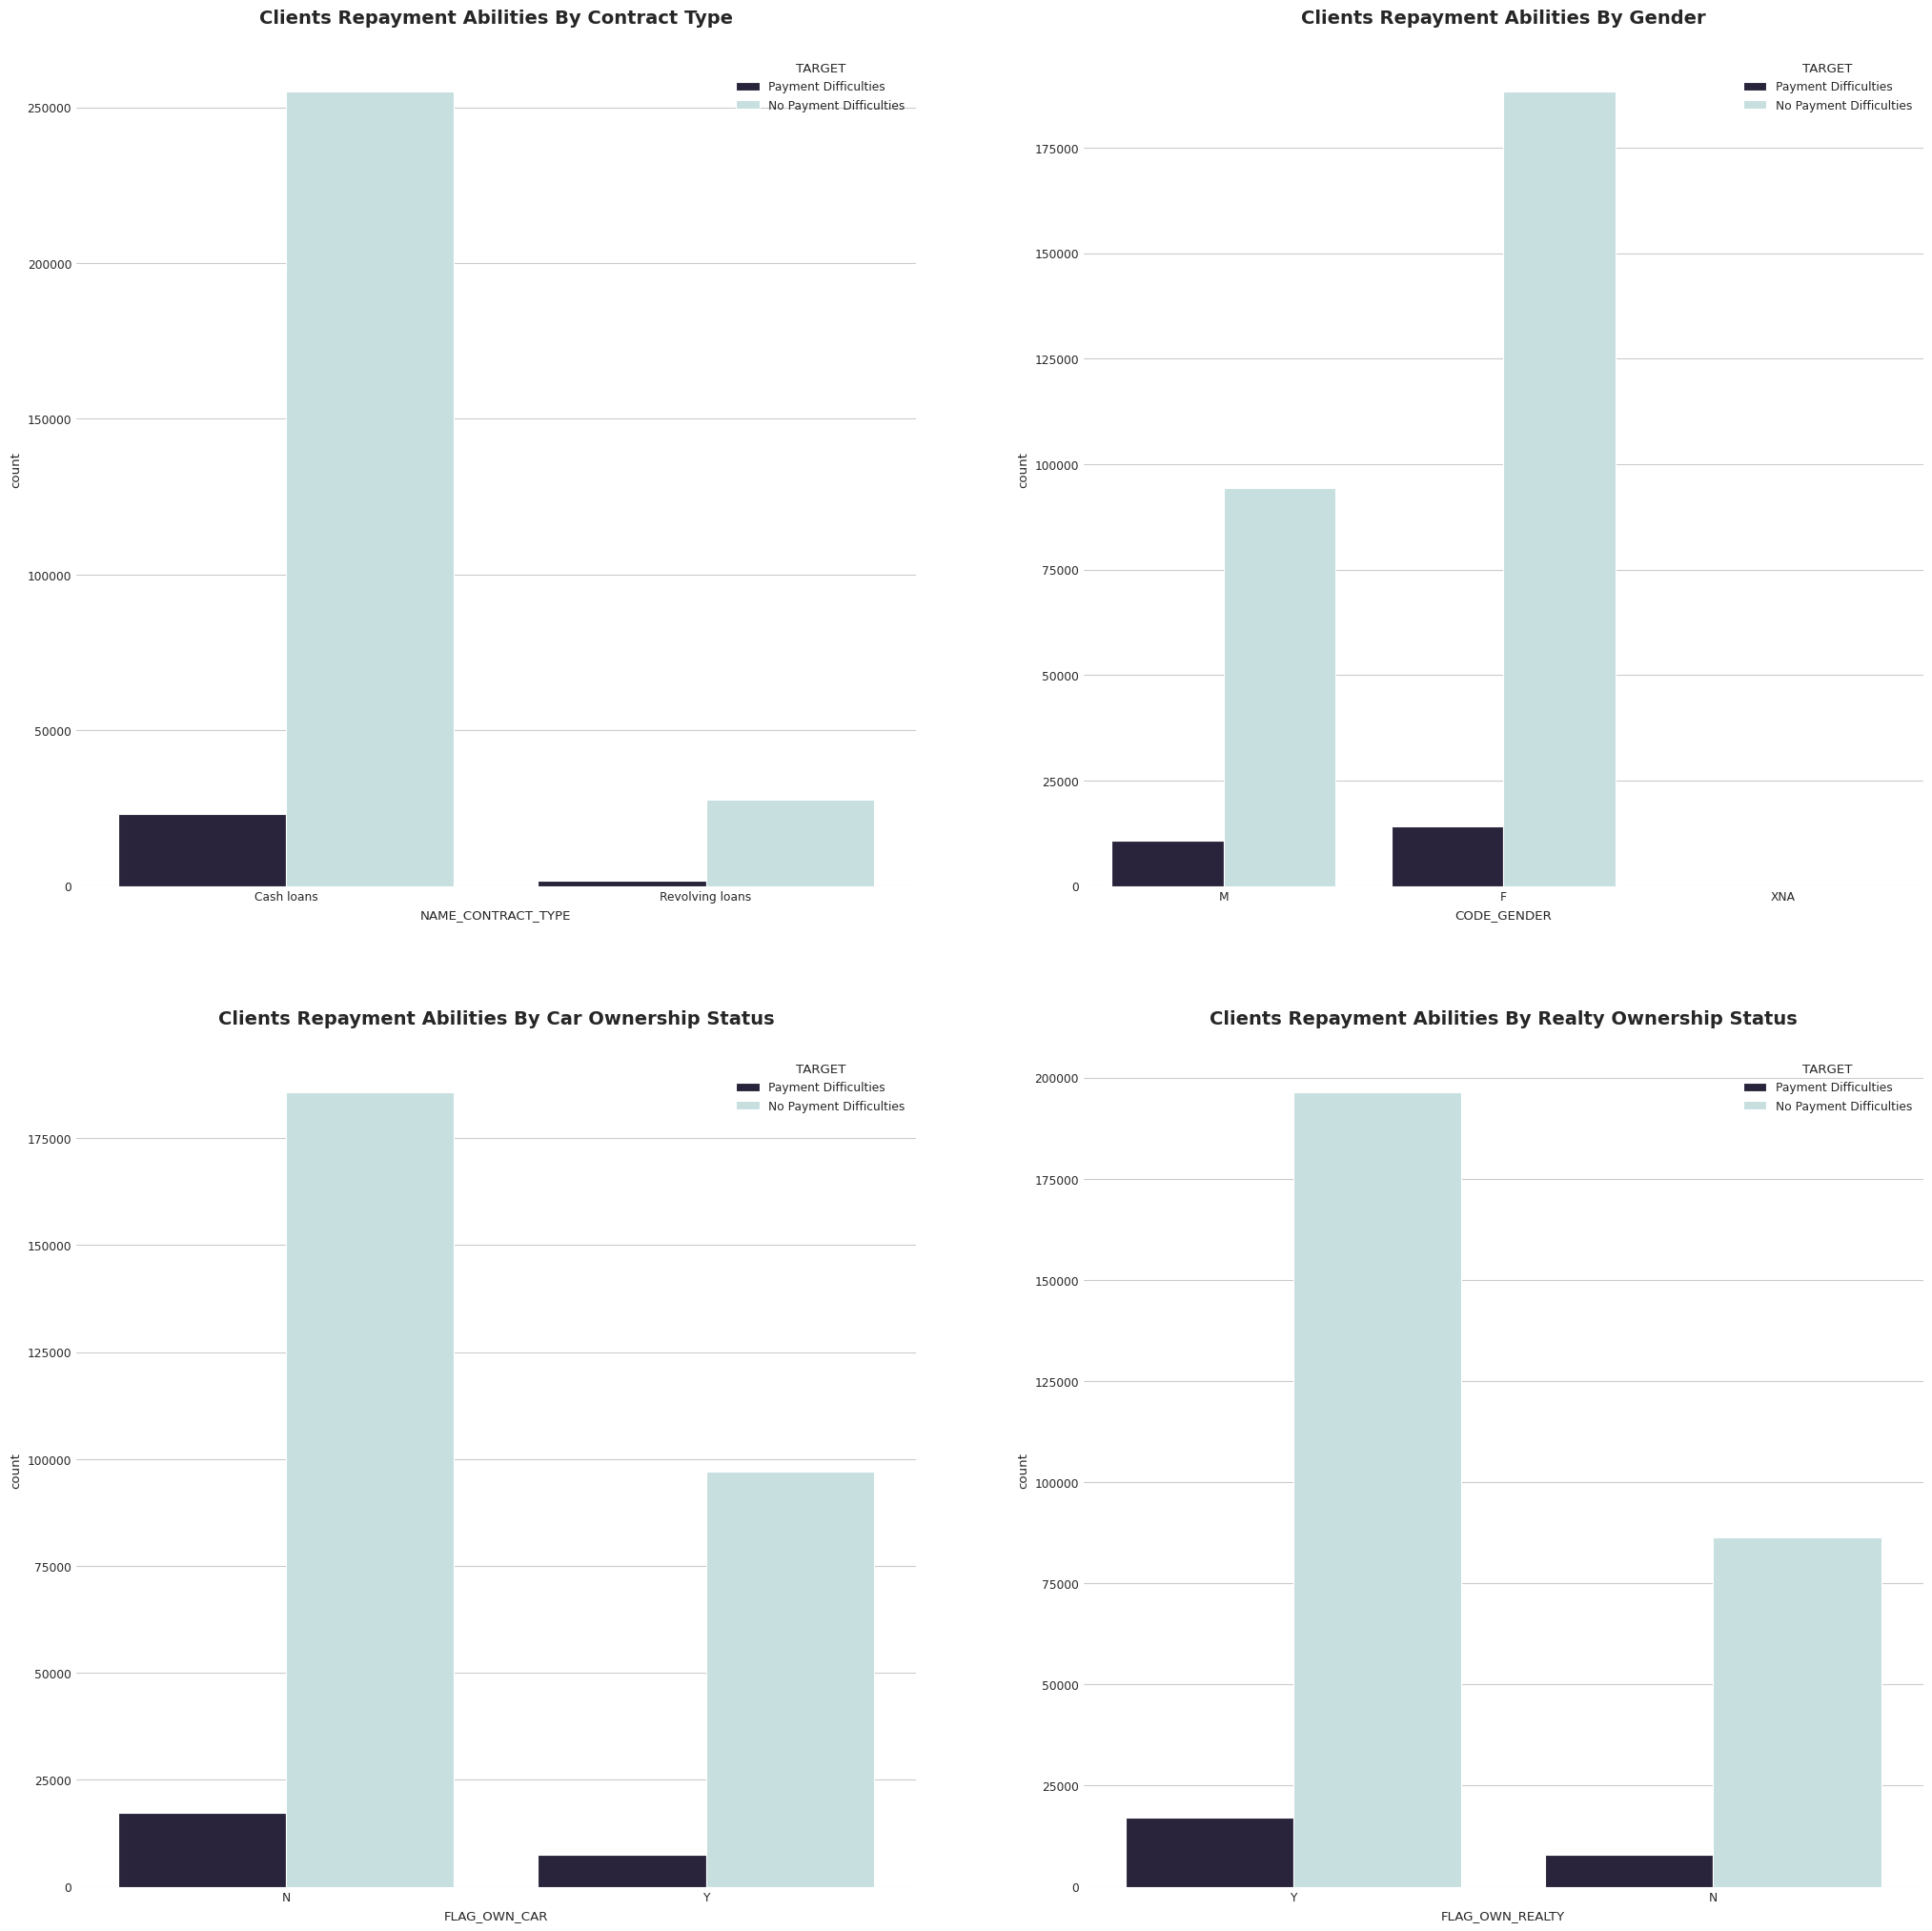

In [ ]:
#Visualization 1
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,25))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Contract Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_CONTRACT_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Gender\n', fontweight='bold', fontsize=14)
sns.countplot(x='CODE_GENDER', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Car Ownership Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='FLAG_OWN_CAR', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Realty Ownership Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='FLAG_OWN_REALTY', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][1])

**a. Contract Type vs Target**

In [ ]:
ct = train.groupby(by=['NAME_CONTRACT_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Contract Type')
ct.sort_values(by='SK_ID_CURR', ascending=False)
ct.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Contract Type


,NAME_CONTRACT_TYPE,TARGET,SK_ID_CURR
0,Cash loans,No Payment Difficulties,255011
1,Cash loans,Payment Difficulties,23221
2,Revolving loans,No Payment Difficulties,27675
3,Revolving loans,Payment Difficulties,1604


In this dataset, around 278.000 **cash loans** accounted for the majority of total loans while **revolving loans** have a much lower amount of around 29.000 compared to cash loans.

**b. Gender vs Target**

In [ ]:
train['CODE_GENDER'] = train['CODE_GENDER'].replace(['F','M'],['Female','Male'])

In [ ]:
gt = train.groupby(by=['CODE_GENDER','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Gender')
gt.sort_values(by='SK_ID_CURR', ascending=False)
gt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Gender


,CODE_GENDER,TARGET,SK_ID_CURR
0,Female,No Payment Difficulties,188278
1,Female,Payment Difficulties,14170
2,Male,No Payment Difficulties,94404
3,Male,Payment Difficulties,10655
4,XNA,No Payment Difficulties,4


In [ ]:
df_train[['CODE_GENDER','TARGET']].groupby(['CODE_GENDER'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,CODE_GENDER,TARGET
1,M,0.101419
0,F,0.069993
2,XNA,0.000000


There are about 202.448 (10%) loan application applied by **women**, and about 105.059 (7%) application applied by **men**.

**c. Car Ownership Status vs Target**

In [ ]:
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace(['Y','N'],['Yes','No'])

In [ ]:
ot = train.groupby(by=['FLAG_OWN_CAR','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Car Ownership Status')
ot.sort_values(by='SK_ID_CURR', ascending=False)
ot.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Car Ownership Status


,FLAG_OWN_CAR,TARGET,SK_ID_CURR
0,No,No Payment Difficulties,185675
1,No,Payment Difficulties,17249
2,Yes,No Payment Difficulties,97011
3,Yes,Payment Difficulties,7576


In [ ]:
df_train[['FLAG_OWN_CAR','TARGET']].groupby(['FLAG_OWN_CAR'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_CAR,TARGET
0,N,0.085002
1,Y,0.072437


Clients who **own a car (±8%)** had the problems in repaying the loan compared to the clients who **not own a car (±7%)**. However the difference is not very significant.

**d. Realty Ownership Status vs Target**

In [ ]:
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace(['Y','N'],['Yes','No'])

In [ ]:
rt = train.groupby(by=['FLAG_OWN_REALTY','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Realty Ownership Status')
rt.sort_values(by='SK_ID_CURR', ascending=False)
rt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Realty Ownership Status


,FLAG_OWN_REALTY,TARGET,SK_ID_CURR
0,No,No Payment Difficulties,86357
1,No,Payment Difficulties,7842
2,Yes,No Payment Difficulties,196329
3,Yes,Payment Difficulties,16983


In [ ]:
df_train[['FLAG_OWN_REALTY','TARGET']].groupby(['FLAG_OWN_REALTY'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_REALTY,TARGET
0,N,0.083249
1,Y,0.079616


Clients who **own a house/flat (±8%)** had the problems in repaying the loan compared to the clients who **not own a house/flat (±7%)**. However the difference is not very significant.

**2. Suite Type, Income Type, Education Type, and Family Status**

<Axes: title={'center': '\nClients Repayment Abilities By Family Status\n'}, xlabel='NAME_FAMILY_STATUS', ylabel='count'>

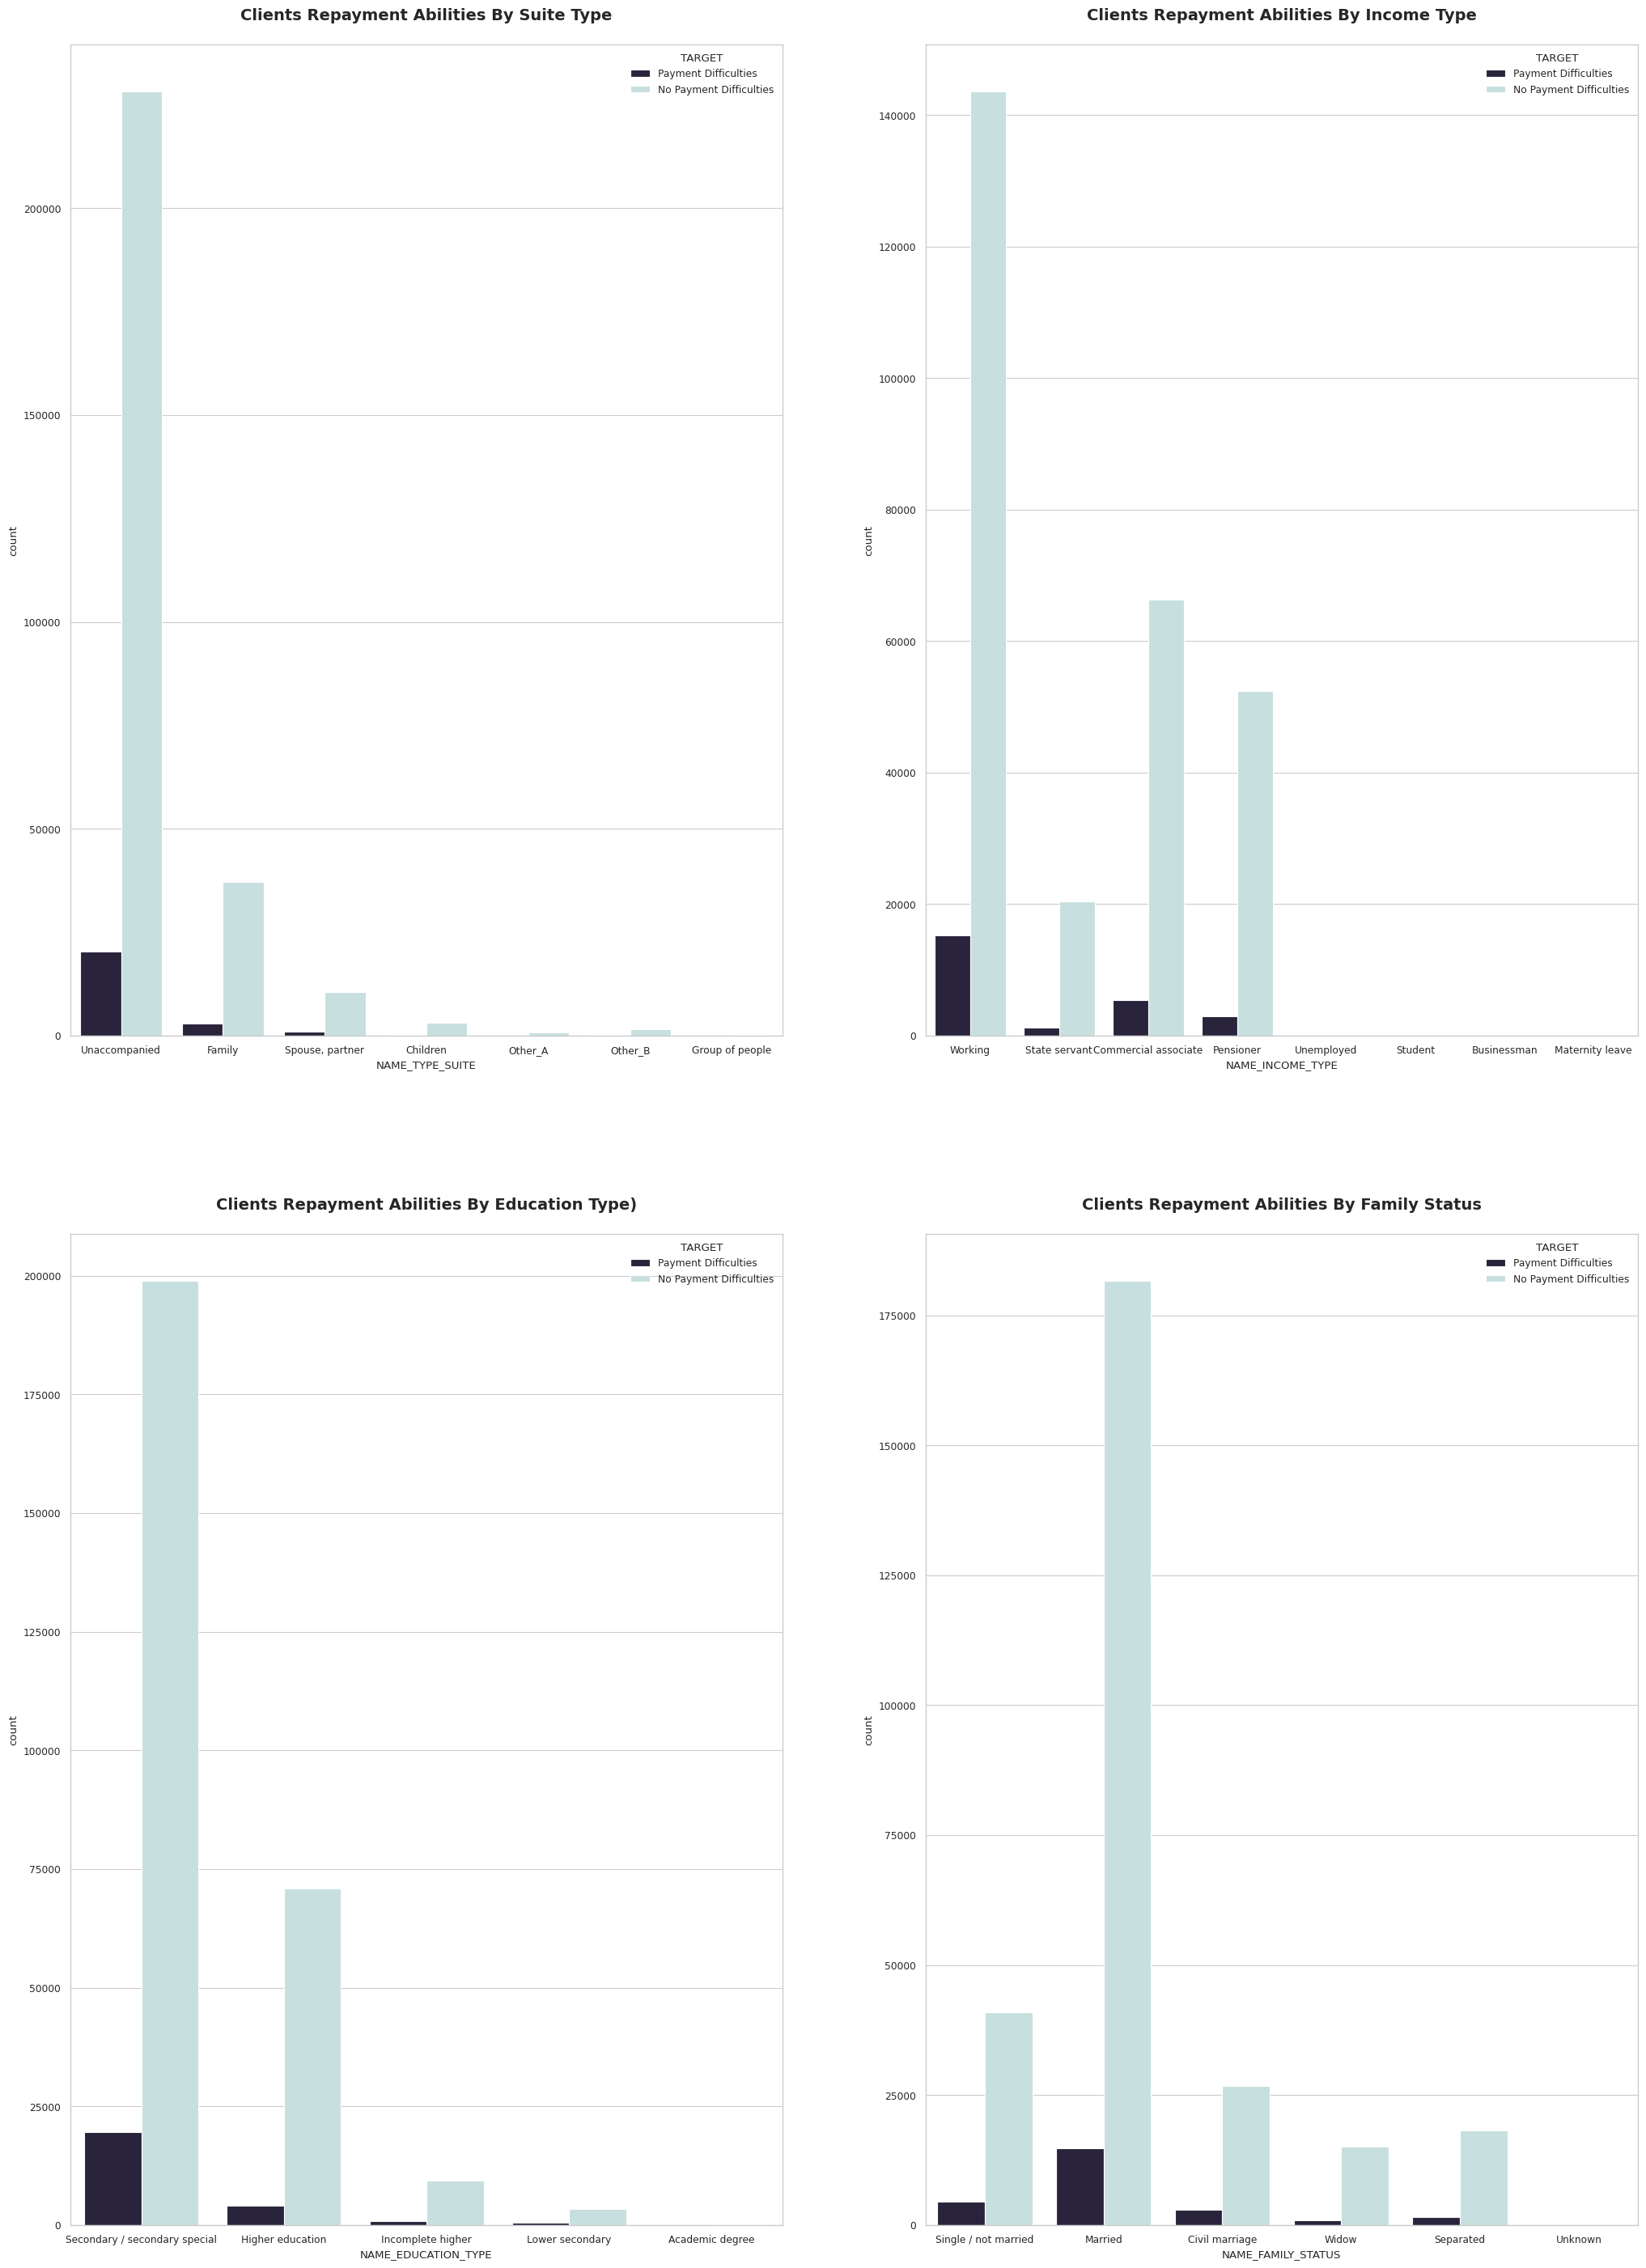

In [ ]:
#Visualization 2
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,35))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Suite Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_TYPE_SUITE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Income Type\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_INCOME_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Education Type)\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_EDUCATION_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Family Status\n', fontweight='bold', fontsize=14)
sns.countplot(x='NAME_FAMILY_STATUS', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][1])

**a. Suite Type vs Target**

In [ ]:
st = train.groupby(by=['NAME_TYPE_SUITE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Suite Type')
st.sort_values(by='SK_ID_CURR', ascending=False)
st.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Suite Type


,NAME_TYPE_SUITE,TARGET,SK_ID_CURR
0,Children,No Payment Difficulties,3026
1,Children,Payment Difficulties,241
2,Family,No Payment Difficulties,37140
3,Family,Payment Difficulties,3009
4,Group of people,No Payment Difficulties,248
5,Group of people,Payment Difficulties,23
6,Other_A,No Payment Difficulties,790
7,Other_A,Payment Difficulties,76
8,Other_B,No Payment Difficulties,1596
9,Other_B,Payment Difficulties,174


In [ ]:
df_train[['NAME_TYPE_SUITE','TARGET']].groupby(['NAME_TYPE_SUITE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_TYPE_SUITE,TARGET
4,Other_B,0.098305
3,Other_A,0.087760
2,Group of people,0.084871
6,Unaccompanied,0.081830
5,"Spouse, partner",0.078716
1,Family,0.074946
0,Children,0.073768


Clients who are accompanied by **Other_B (±10%)** have a higher percentage of having difficulty repaying the loan. 

**b. Income Type vs Target**

In [ ]:
rt = train.groupby(by=['NAME_INCOME_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Income Type')
rt.sort_values(by='SK_ID_CURR', ascending=False)
rt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Income Type


,NAME_INCOME_TYPE,TARGET,SK_ID_CURR
0,Businessman,No Payment Difficulties,10
1,Commercial associate,No Payment Difficulties,66257
2,Commercial associate,Payment Difficulties,5360
3,Maternity leave,No Payment Difficulties,3
4,Maternity leave,Payment Difficulties,2
5,Pensioner,No Payment Difficulties,52380
6,Pensioner,Payment Difficulties,2982
7,State servant,No Payment Difficulties,20454
8,State servant,Payment Difficulties,1249
9,Student,No Payment Difficulties,18


In [ ]:
df_train[['NAME_INCOME_TYPE','TARGET']].groupby(['NAME_INCOME_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_INCOME_TYPE,TARGET
2,Maternity leave,0.400000
6,Unemployed,0.363636
7,Working,0.095885
1,Commercial associate,0.074843
4,State servant,0.057550
3,Pensioner,0.053864
0,Businessman,0.000000
5,Student,0.000000


Clients who have income type of **working** have applied for a lager majority of loans (about 158.774).

Clients with the income type of **businessman** and **student** have no difficulty in repaying their loans.

Clients with the income type of **maternity leaves** and **unemplooyed** have the highest percentage (about 40% and 36%) of TARGET=1 that is having problem in repaying the loans.

**c. Education Type vs Target**

In [ ]:
et = train.groupby(by=['NAME_EDUCATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Education Type')
et.sort_values(by='SK_ID_CURR', ascending=False)
et.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Education Type


,NAME_EDUCATION_TYPE,TARGET,SK_ID_CURR
0,Academic degree,No Payment Difficulties,161
1,Academic degree,Payment Difficulties,3
2,Higher education,No Payment Difficulties,70854
3,Higher education,Payment Difficulties,4009
4,Incomplete higher,No Payment Difficulties,9405
5,Incomplete higher,Payment Difficulties,872
6,Lower secondary,No Payment Difficulties,3399
7,Lower secondary,Payment Difficulties,417
8,Secondary / secondary special,No Payment Difficulties,198867
9,Secondary / secondary special,Payment Difficulties,19524


In [ ]:
df_train[['NAME_EDUCATION_TYPE','TARGET']].groupby(['NAME_EDUCATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_EDUCATION_TYPE,TARGET
3,Lower secondary,0.109277
4,Secondary / secondary special,0.089399
2,Incomplete higher,0.084850
1,Higher education,0.053551
0,Academic degree,0.018293


A large number of applications (218.000) are filled by client having **secondary education** followed by people with **higher education** (75.000).

Clients with education type of **lower secondary** has the highest percentage (around 10%) of TARGET=1 that is having problem in repaying the loans.

**d. Family Status vs Target**

In [ ]:
ft = train.groupby(by=['NAME_FAMILY_STATUS','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Family Status')
ft.sort_values(by='SK_ID_CURR', ascending=False)
ft.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Family Status


,NAME_FAMILY_STATUS,TARGET,SK_ID_CURR
0,Civil marriage,No Payment Difficulties,26814
1,Civil marriage,Payment Difficulties,2961
2,Married,No Payment Difficulties,181582
3,Married,Payment Difficulties,14850
4,Separated,No Payment Difficulties,18150
5,Separated,Payment Difficulties,1620
6,Single / not married,No Payment Difficulties,40987
7,Single / not married,Payment Difficulties,4457
8,Unknown,No Payment Difficulties,2
9,Widow,No Payment Difficulties,15151


In [ ]:
df_train[['NAME_FAMILY_STATUS','TARGET']].groupby(['NAME_FAMILY_STATUS'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_FAMILY_STATUS,TARGET
0,Civil marriage,0.099446
3,Single / not married,0.098077
2,Separated,0.081942
1,Married,0.075599
5,Widow,0.058242
4,Unknown,0.000000


Clients who are **married** have applied for a larger majority of loans, there are bout 196.432 loan applications.

Clients with family status of **civil mariage** and **single** have the highest percentage (around 9%) that is having problem in repaying the loans.

**3. Housing Type, Occupation Type, Process Day, and Organization Type**

**a. Housing Type vs Target**

In [ ]:
ht = train.groupby(by=['NAME_HOUSING_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Housing Type')
ht.sort_values(by='SK_ID_CURR', ascending=False)
ht.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Housing Type


,NAME_HOUSING_TYPE,TARGET,SK_ID_CURR
0,Co-op apartment,No Payment Difficulties,1033
1,Co-op apartment,Payment Difficulties,89
2,House / apartment,No Payment Difficulties,251596
3,House / apartment,Payment Difficulties,21272
4,Municipal apartment,No Payment Difficulties,10228
5,Municipal apartment,Payment Difficulties,955
6,Office apartment,No Payment Difficulties,2445
7,Office apartment,Payment Difficulties,172
8,Rented apartment,No Payment Difficulties,4280
9,Rented apartment,Payment Difficulties,601


In [ ]:
df_train[['NAME_HOUSING_TYPE','TARGET']].groupby(['NAME_HOUSING_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_HOUSING_TYPE,TARGET
4,Rented apartment,0.123131
5,With parents,0.116981
2,Municipal apartment,0.085397
0,Co-op apartment,0.079323
1,House / apartment,0.077957
3,Office apartment,0.065724


Clients with housing type of **rented apartment** has the highest perentage (around 12%) in difficulty repaying the loans.

Text(0.5, 0, '\nHousing Type')

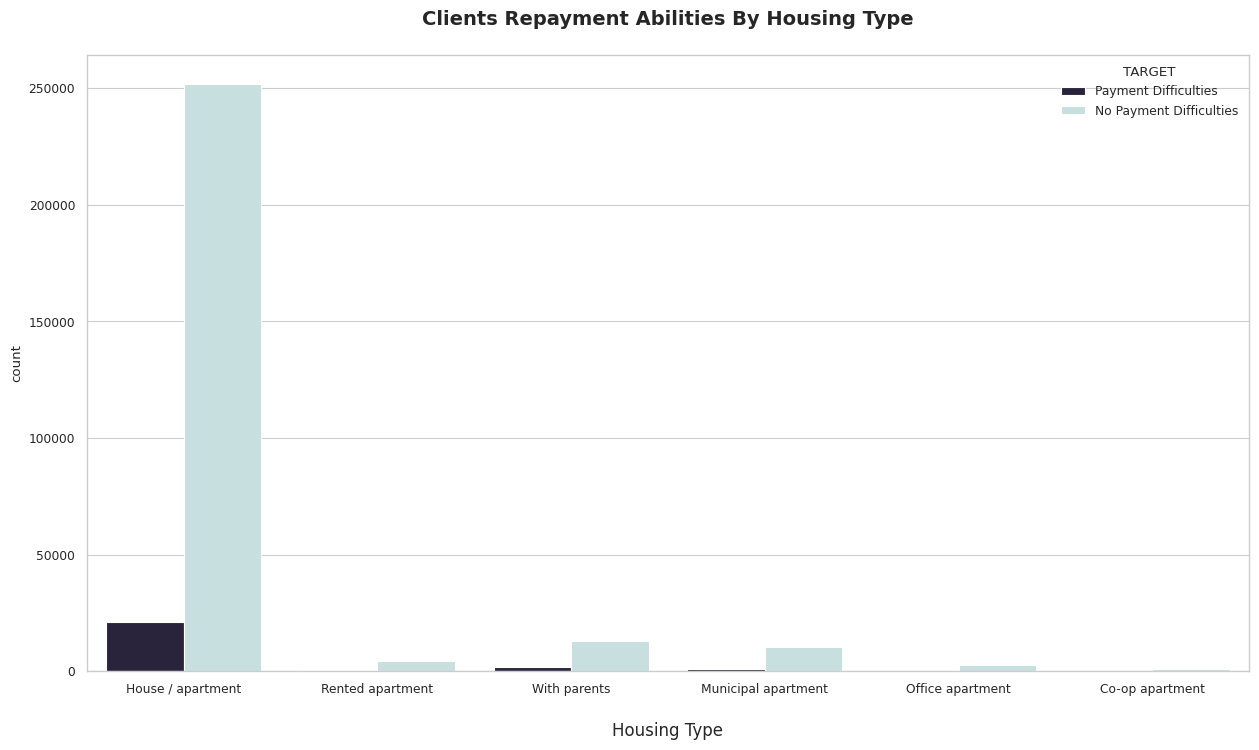

In [ ]:
#Visualization
plt.figure(figsize=(15,8))
fig = sns.countplot(x='NAME_HOUSING_TYPE', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r')
plt.title('Clients Repayment Abilities By Housing Type\n', fontweight='bold', fontsize=14)
plt.xlabel('\nHousing Type', fontsize=12)

Clients living in **house/apartments** has the highest number of loan applications equal to 272.000.

**b. Occupation Type vs Target**

In [ ]:
ot = train.groupby(by=['OCCUPATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Occupation Type')
ot.sort_values(by='SK_ID_CURR', ascending=False)
ot.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Occupation Type


,OCCUPATION_TYPE,TARGET,SK_ID_CURR
0,Accountants,No Payment Difficulties,9339
1,Accountants,Payment Difficulties,474
2,Cleaning staff,No Payment Difficulties,4206
3,Cleaning staff,Payment Difficulties,447
4,Cooking staff,No Payment Difficulties,5325
5,Cooking staff,Payment Difficulties,621
6,Core staff,No Payment Difficulties,25832
7,Core staff,Payment Difficulties,1738
8,Drivers,No Payment Difficulties,16496
9,Drivers,Payment Difficulties,2107


In [ ]:
df_train[['OCCUPATION_TYPE','TARGET']].groupby(['OCCUPATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,OCCUPATION_TYPE,TARGET
9,Low-skill Laborers,0.171524
4,Drivers,0.113261
17,Waiters/barmen staff,0.112760
16,Security staff,0.107424
8,Laborers,0.105788
2,Cooking staff,0.104440
14,Sales staff,0.096318
1,Cleaning staff,0.096067
13,Realty agents,0.078562
15,Secretaries,0.070498


A large number of applications (55.000) are filled by clients who work as **Laborers**.

Clients with occupation type of **low-skill laborers** has the highest percentage (around 17%) of TARGET=1 that is having problem in repaying the loans.

**c. Process Day vs Target**

In [ ]:
pt = train.groupby(by=['WEEKDAY_APPR_PROCESS_START','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Process Day')
pt.sort_values(by='SK_ID_CURR', ascending=False)
pt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Process Day


,WEEKDAY_APPR_PROCESS_START,TARGET,SK_ID_CURR
0,FRIDAY,No Payment Difficulties,46237
1,FRIDAY,Payment Difficulties,4101
2,MONDAY,No Payment Difficulties,46780
3,MONDAY,Payment Difficulties,3934
4,SATURDAY,No Payment Difficulties,31182
5,SATURDAY,Payment Difficulties,2670
6,SUNDAY,No Payment Difficulties,14898
7,SUNDAY,Payment Difficulties,1283
8,THURSDAY,No Payment Difficulties,46493
9,THURSDAY,Payment Difficulties,4098


In [ ]:
df_train[['WEEKDAY_APPR_PROCESS_START','TARGET']].groupby(['WEEKDAY_APPR_PROCESS_START'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,WEEKDAY_APPR_PROCESS_START,TARGET
5,TUESDAY,0.083505
6,WEDNESDAY,0.081604
0,FRIDAY,0.081469
4,THURSDAY,0.081003
3,SUNDAY,0.079291
2,SATURDAY,0.078873
1,MONDAY,0.077572


Text(0.5, 0, '\nProcess Day')

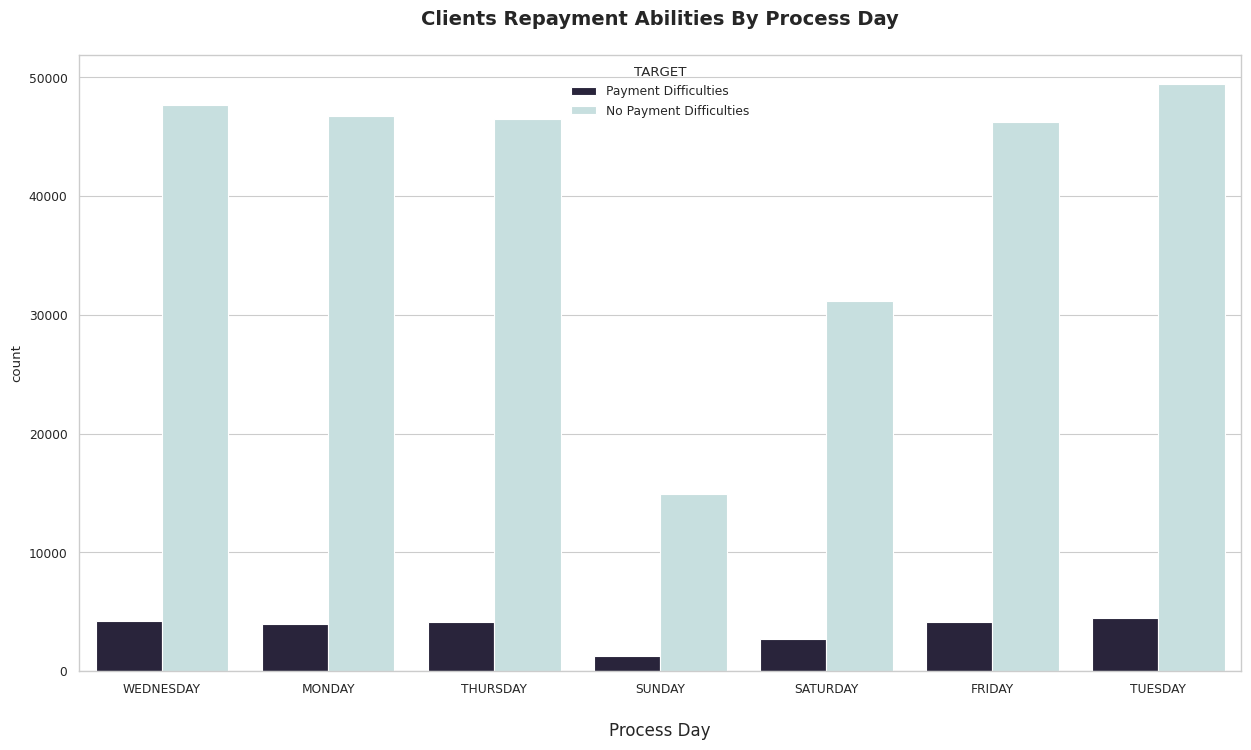

In [ ]:
#Visualization
plt.figure(figsize=(15,8))
fig = sns.countplot(x='WEEKDAY_APPR_PROCESS_START', data = train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r')
plt.title('Clients Repayment Abilities By Process Day\n', fontweight='bold', fontsize=14)
plt.xlabel('\nProcess Day', fontsize=12)

Each application processing day has almost the same percentage (about 7-8%) of TARGET=1 that is having problem in repaying the loans.

**d. Organization Type vs Target**

In [ ]:
tt = train.groupby(by=['ORGANIZATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Suite Type')
tt.sort_values(by='SK_ID_CURR', ascending=False)
tt.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Suite Type


,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
0,Advertising,No Payment Difficulties,394
1,Advertising,Payment Difficulties,35
2,Agriculture,No Payment Difficulties,2197
3,Agriculture,Payment Difficulties,257
4,Bank,No Payment Difficulties,2377
5,Bank,Payment Difficulties,130
6,Business Entity Type 1,No Payment Difficulties,5497
7,Business Entity Type 1,Payment Difficulties,487
8,Business Entity Type 2,No Payment Difficulties,9653
9,Business Entity Type 2,Payment Difficulties,900


In [ ]:
df_train[['ORGANIZATION_TYPE','TARGET']].groupby(['ORGANIZATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,ORGANIZATION_TYPE,TARGET
54,Transport: type 3,0.157540
18,Industry: type 13,0.134328
25,Industry: type 8,0.125000
38,Restaurant,0.117062
7,Construction,0.116798
6,Cleaning,0.111538
14,Industry: type 1,0.110683
20,Industry: type 3,0.106162
36,Realtor,0.106061
1,Agriculture,0.104727


Clients with organization type of **transport: type 3** has the highest percentage (around 15%) of TARGET=1 that is having problem in repaying the loans.

##### **Bivariate: Numerical Features vs Target**

**1. Amount Credit of the Loan vs Target**

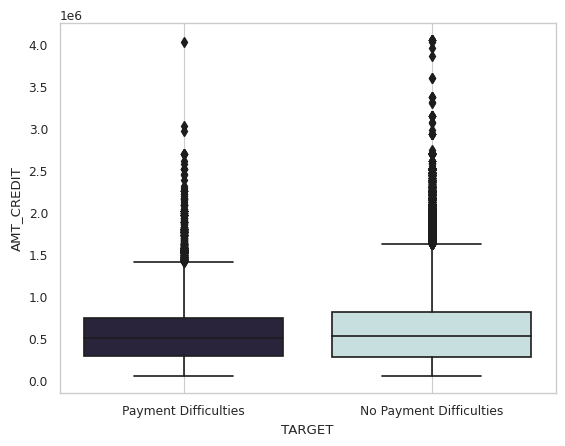

In [ ]:
sns.boxplot(x='TARGET', y='AMT_CREDIT', data=train, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

Median value of the credit amount of the clients who have no payment difficulties is slightly larger than the median value of clients who have payment difficulties. It means that the clients with higher credit amount of the loan have a slightly higher chances of being capable of repaying the loan than the clients with lower credit amount.

**2. Amount Income vs Target**

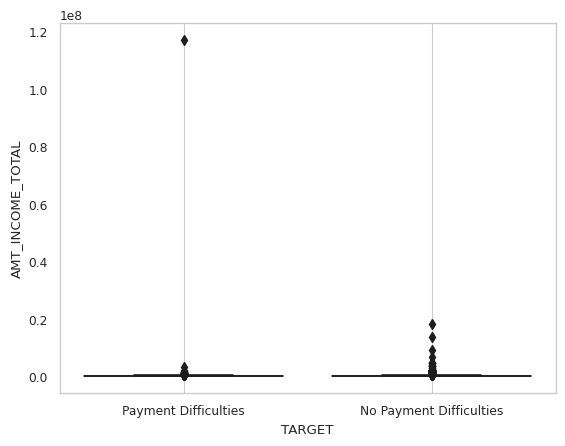

In [ ]:
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=train, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

Both clients who have payment difficulties as well as clients who have no payment difficulties, have mostly the same value. However, as the client's income increases, the probability that clients will not have difficulty repaying the loan also increases.

**3. Age vs Target**

In [ ]:
no_age = df_train[df_train['TARGET']==0]['DAYS_BIRTH'].values/-365
yes_age = df_train[df_train['TARGET']==1]['DAYS_BIRTH'].values/-365

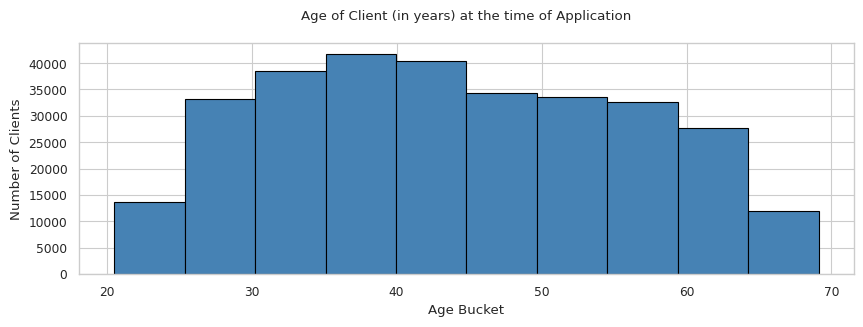

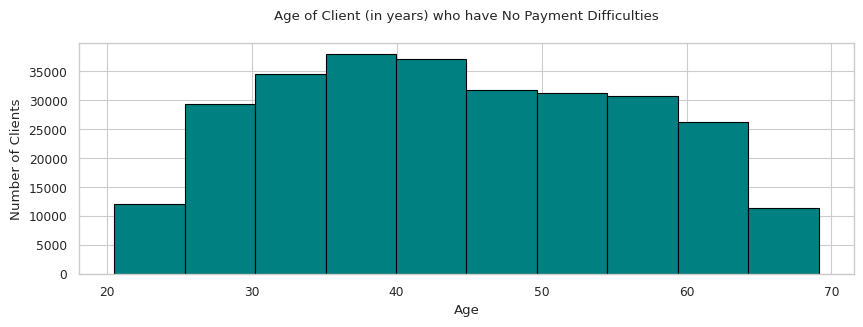

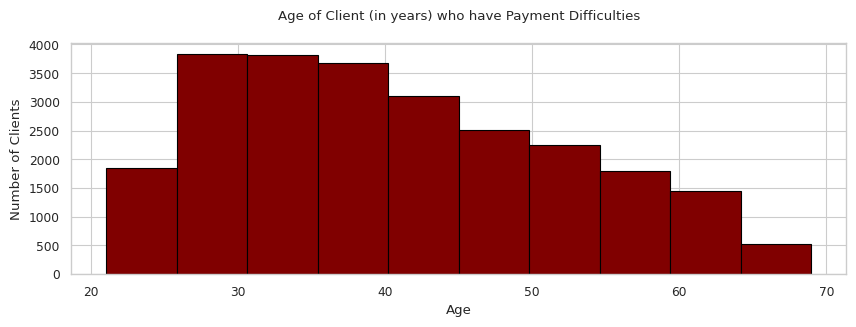

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(df_train['DAYS_BIRTH'].values/-365, bins=10, edgecolor='black', color='steelblue')
plt.title('Age of Client (in years) at the time of Application\n')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(no_age, bins=10, edgecolor='black', color='teal')
plt.title('Age of Client (in years) who have No Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(yes_age, bins=10, edgecolor='black', color='maroon')
plt.title('Age of Client (in years) who have Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

From the diagram, we know that most number of clients who apply for loans are in the range of 35-40 years, followed by clients in the range of 40-45 years. Meanwhile, the number of applicants for clients aged <25 or age >65 is very low.

Clients who have no payment difficulties are client in the range of 35-45 years. While clients who have payment difficulties are client in the range of 25-35 years.

##### **Multivariant Visualization**

######**Grouped by Realty Ownership Status**

**1. Car Ownership Status, The Number of Children, Target, and House/Flat Ownership Statue**

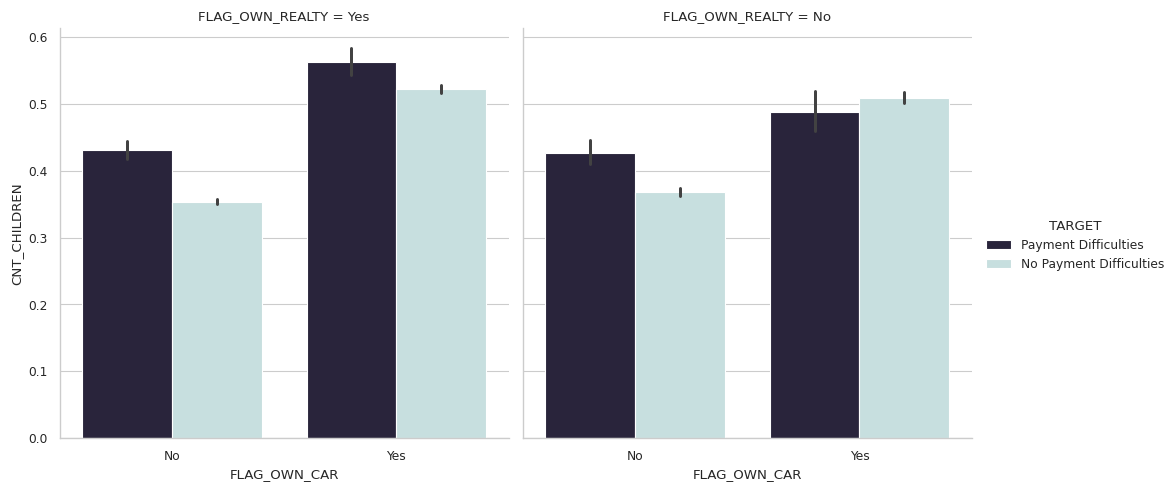

In [ ]:
sns.catplot(x = 'FLAG_OWN_CAR',
            y = 'CNT_CHILDREN', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)
plt.show()

Client who **own a car** and a **house/flat** have a problem repaying the loans for a high number of children compared to clients who do not own house/flat

**2. Income Type, Amount of Goods Price, Target, and House/Flat Ownership Status**

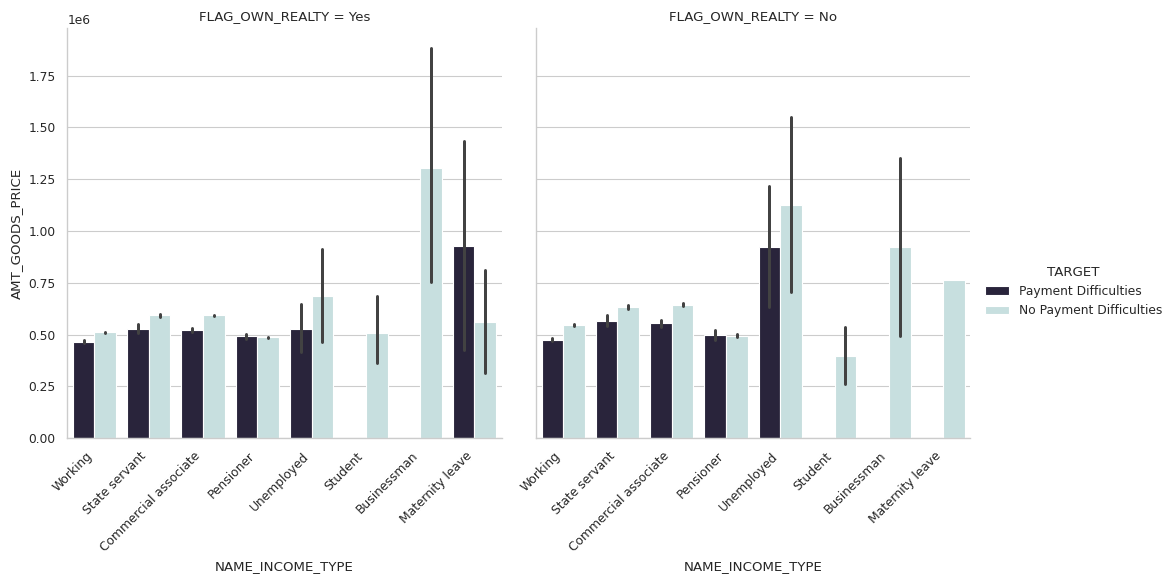

In [ ]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_GOODS_PRICE', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Clients with income type of **maternity leave** in FLAG_OWN_REALTY = Yes (i.e own a house/flat) have a problem repaying the loans compared to when FLAG_OWN_REALTY = No (i.e not own a house/flat).

**3. Family Status, Amount of Income, Target, and House/Flat Ownership Status**

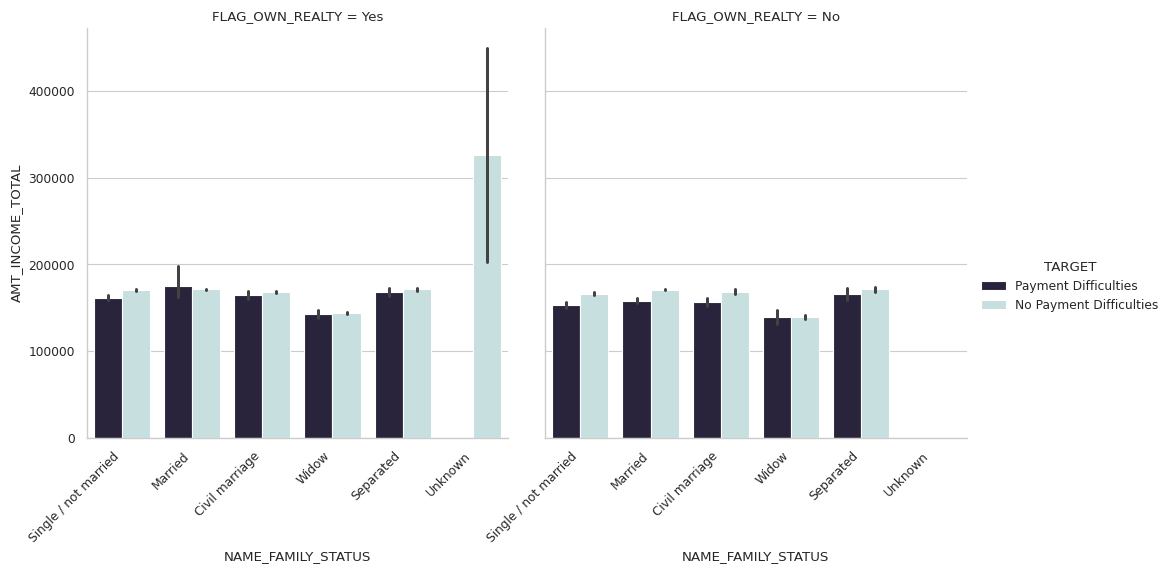

In [ ]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_INCOME_TOTAL', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
train.groupby(by=['NAME_FAMILY_STATUS','FLAG_OWN_REALTY', 'TARGET'], as_index=False)['AMT_INCOME_TOTAL'].mean()

,NAME_FAMILY_STATUS,FLAG_OWN_REALTY,TARGET,AMT_INCOME_TOTAL
0,Civil marriage,No,No Payment Difficulties,168536.777268
1,Civil marriage,No,Payment Difficulties,156693.366523
2,Civil marriage,Yes,No Payment Difficulties,168476.458185
3,Civil marriage,Yes,Payment Difficulties,164301.462106
4,Married,No,No Payment Difficulties,171091.299446
5,Married,No,Payment Difficulties,158015.694066
6,Married,Yes,No Payment Difficulties,171129.614770
7,Married,Yes,Payment Difficulties,174888.788155
8,Separated,No,No Payment Difficulties,171421.821114
9,Separated,No,Payment Difficulties,165808.993458


Clients who are **married** and **own a house/flat** (FLAG_OWN_REALTY = Yes) have problem repaying the loans for a medium amount of income compared to when client not own a house/flat (FLAG_OWN_REALTY = No).

######**Grouped by Car Ownership Status**

**1.Contract Type, The Number of Childre, Target, and Car Ownership Status**

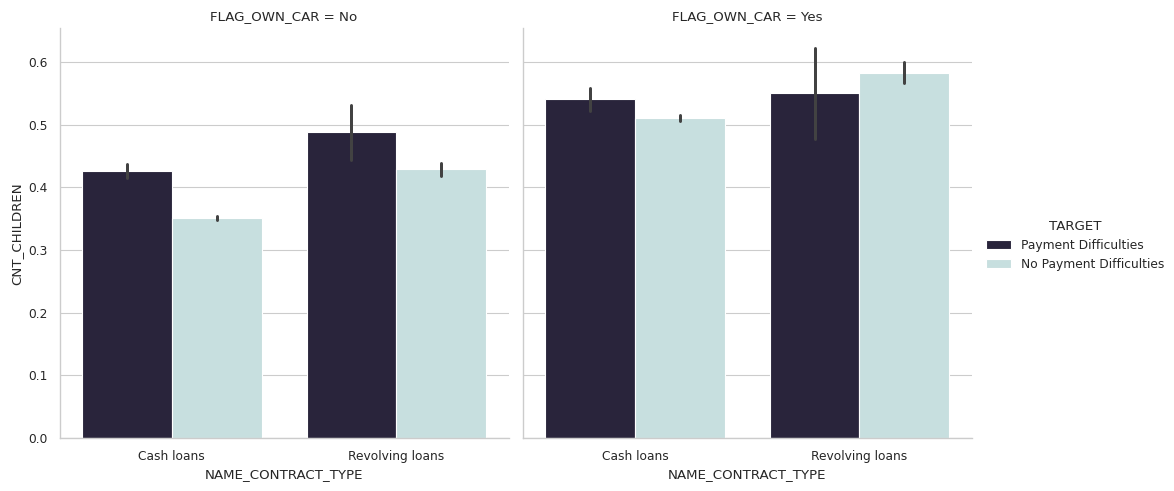

In [ ]:
sns.catplot(x = 'NAME_CONTRACT_TYPE',
            y = 'CNT_CHILDREN', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_CAR', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)
plt.show()

**Revolving loans** in FLAG_OWN_CAR = No (i.e not own a ccar) have problem repaying the loans compared to when FLAG_OWN_CAR = Yes.

######**Grouped by Contract Type**

**1. Income Type, Amount of Credit, Target, and Contract Type**

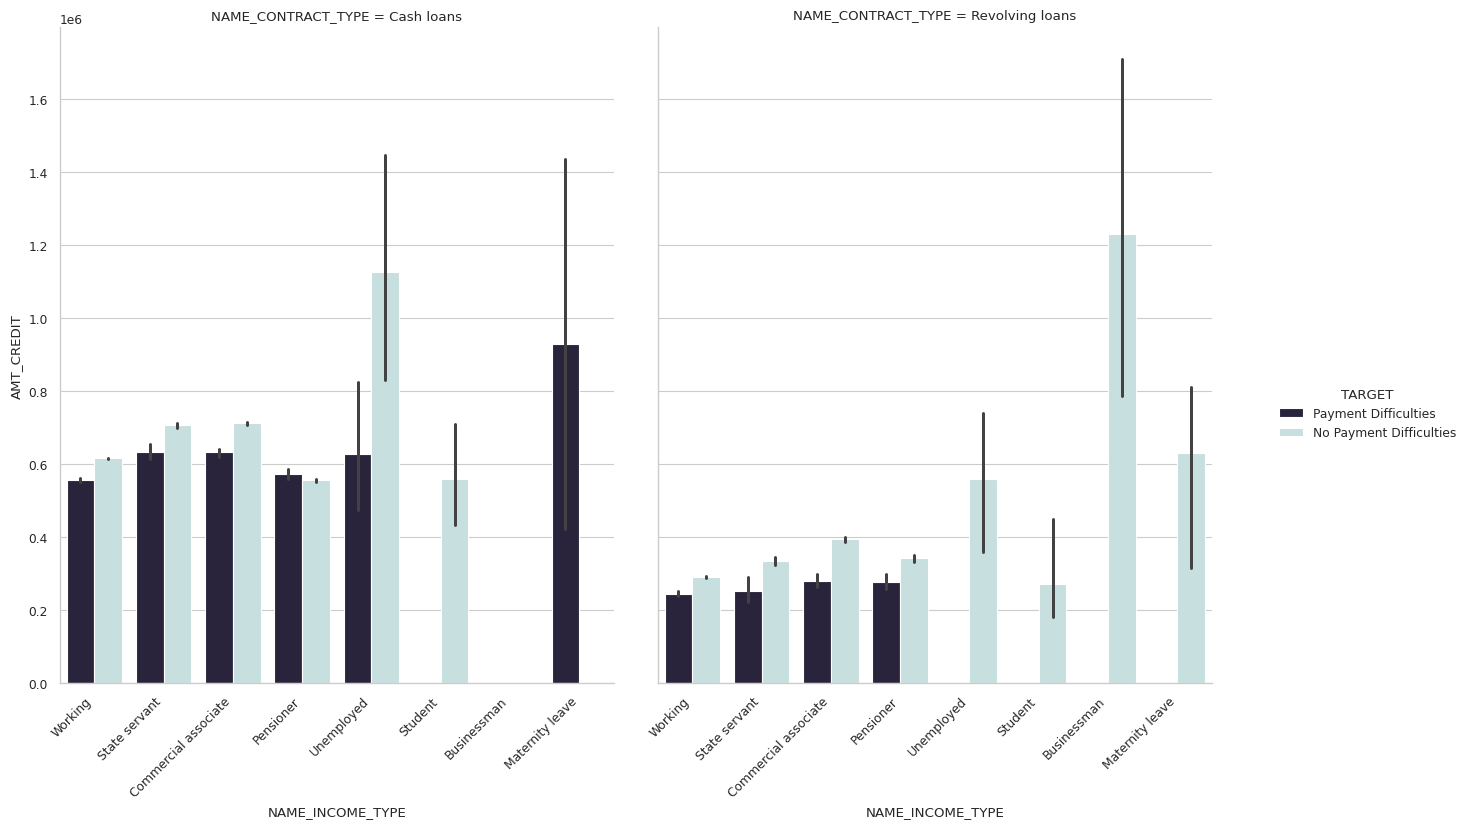

In [ ]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'NAME_CONTRACT_TYPE', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.gcf().set_size_inches(15, 8)
plt.show()

In [ ]:
train.groupby(by=['NAME_INCOME_TYPE','NAME_CONTRACT_TYPE', 'TARGET'], as_index=False)['SK_ID_CURR'].count()
train.groupby(by=['NAME_INCOME_TYPE','NAME_CONTRACT_TYPE', 'TARGET'], as_index=False)['AMT_CREDIT'].mean()

,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,TARGET,AMT_CREDIT
0,Businessman,Revolving loans,No Payment Difficulties,1.228500e+06
1,Commercial associate,Cash loans,No Payment Difficulties,7.114464e+05
2,Commercial associate,Cash loans,Payment Difficulties,6.315081e+05
3,Commercial associate,Revolving loans,No Payment Difficulties,3.933160e+05
4,Commercial associate,Revolving loans,Payment Difficulties,2.806419e+05
5,Maternity leave,Cash loans,Payment Difficulties,9.292500e+05
6,Maternity leave,Revolving loans,No Payment Difficulties,6.300000e+05
7,Pensioner,Cash loans,No Payment Difficulties,5.547979e+05
8,Pensioner,Cash loans,Payment Difficulties,5.718242e+05
9,Pensioner,Revolving loans,No Payment Difficulties,3.417436e+05


Clients with income type of **maternity leave** with **cash loan** have problems repaying the loans for a medium credit amount of the loan. Meanwhile clients with income type of maternity leave and revolving loans have no difficulty repaying the loans.

More than 50% **Unemployed** clients with **cash loan** have problems repaying loans with medium credit amounts of the loan. While all unemployed clients with revolvingg loans have no difficulty repaying the loan.

**Student** clients have no difficulty repaying the loans either with cash loan or revolving loan for a low to medium credit amount of the loan.

######**Grouped by Rating of Region where Client Lives**

**1. Housing Type, Amound of Credit of Loan, Target, and Rating of Region where Client Lives**

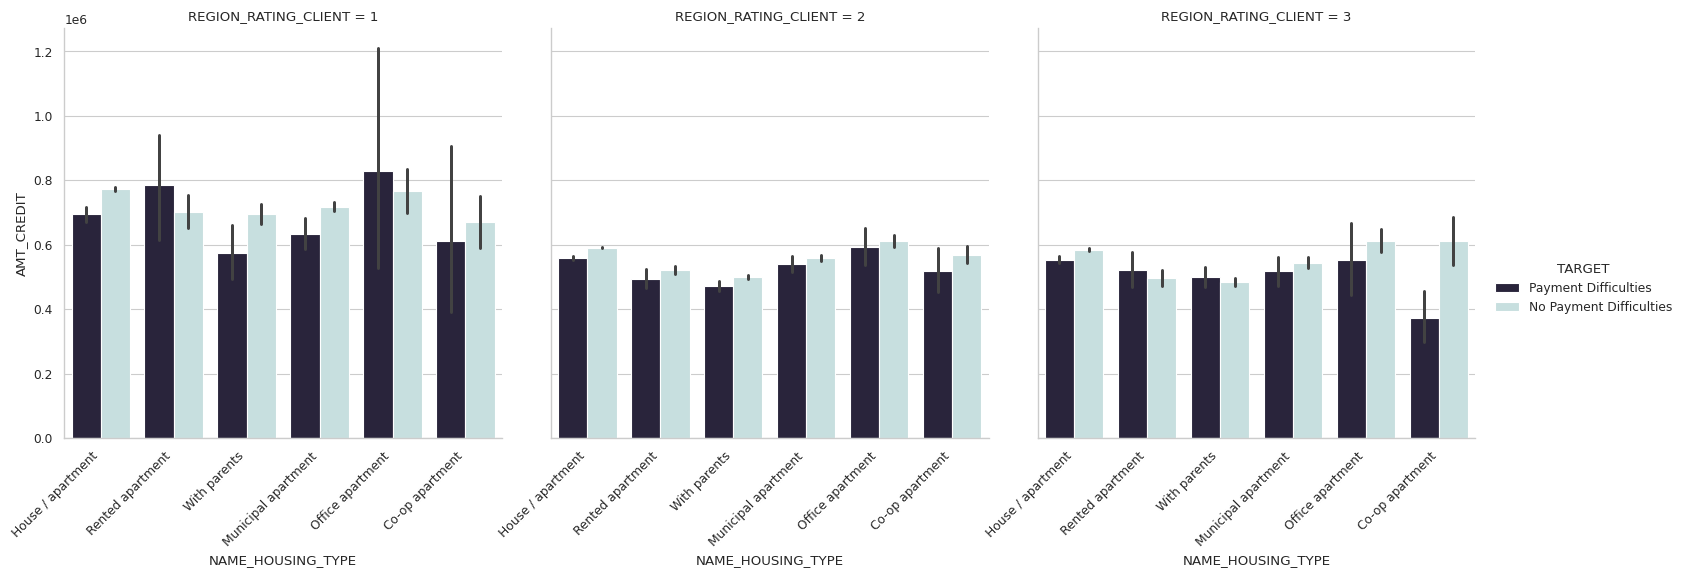

In [ ]:
fig = sns.catplot(x = 'NAME_HOUSING_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Clients who lives in **rented apartment** and **office apartment** and their region have a rating of 1, have a problem repaying the loans compared to client in region with rating of 2 for a medium credit amount of the loan.

**2. Education Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives**

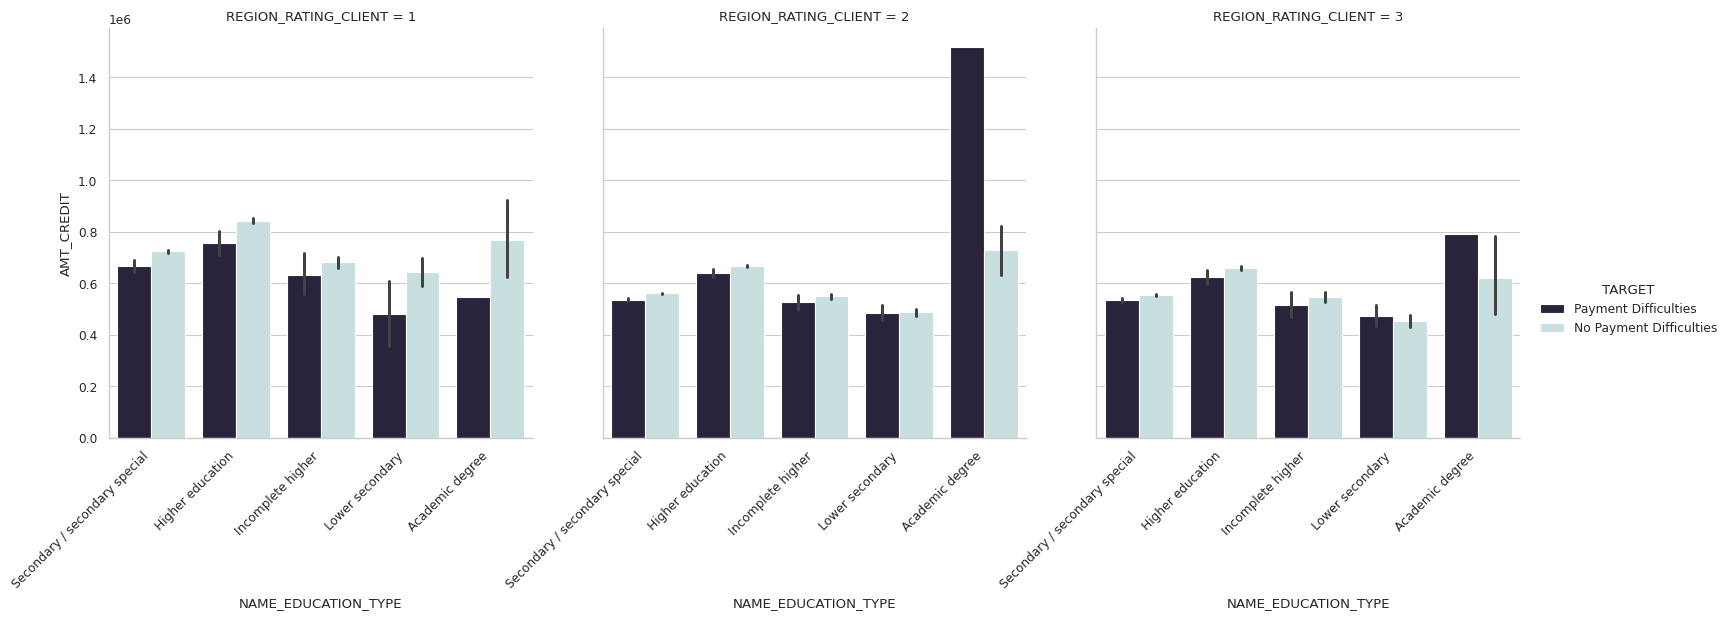

In [ ]:
fig = sns.catplot(x = 'NAME_EDUCATION_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

Client who have **acedemic degree** and lives in region with **rating of 2** have a problem repaying the loans for higher amount credit of the loan.

Client with the same degree but lives in region with rating of 3 have problem repaying the loans for a medium amound of credit of the loan.

**3. Family Status, Amount Credit of Loan, Target, and Rating of Region where Client Lives**

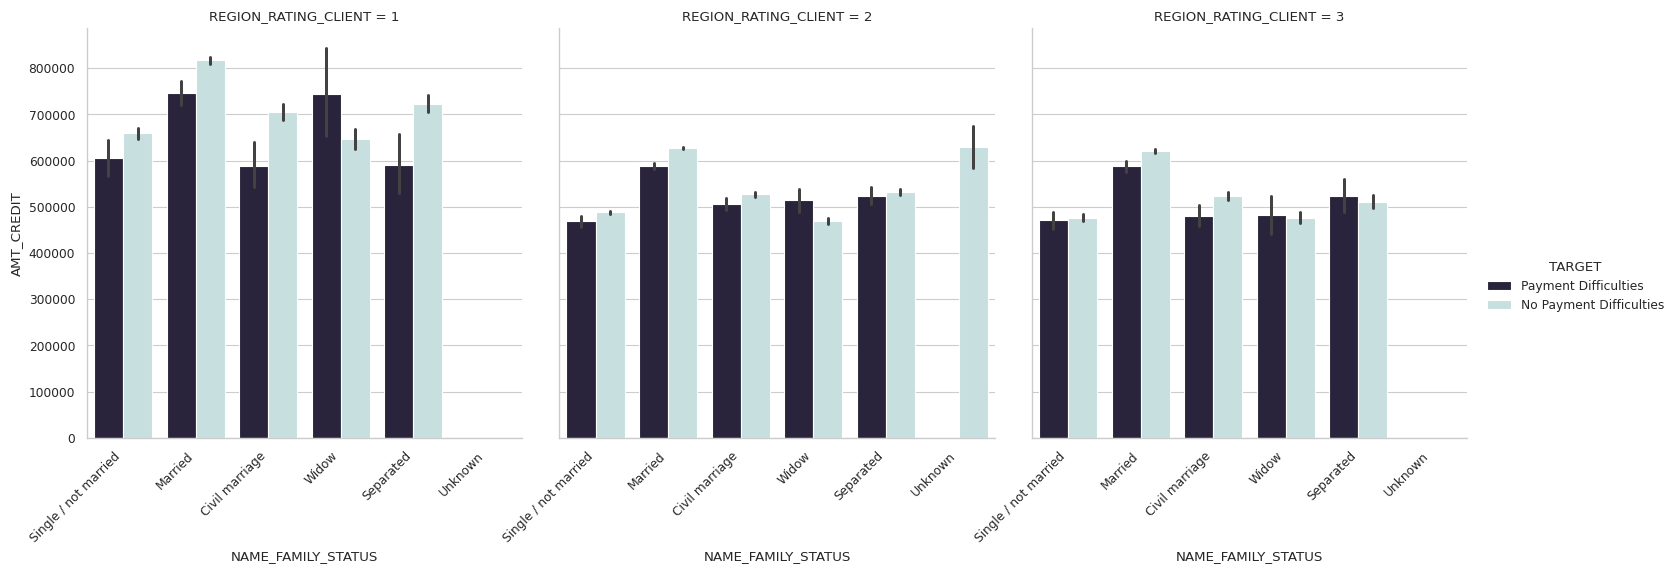

In [ ]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
train.groupby(by=['NAME_FAMILY_STATUS','REGION_RATING_CLIENT', 'TARGET'], as_index=False)['AMT_CREDIT'].mean()

,NAME_FAMILY_STATUS,REGION_RATING_CLIENT,TARGET,AMT_CREDIT
0,Civil marriage,1,No Payment Difficulties,704262.697373
1,Civil marriage,1,Payment Difficulties,588802.878505
2,Civil marriage,2,No Payment Difficulties,526937.803789
3,Civil marriage,2,Payment Difficulties,505484.586757
4,Civil marriage,3,No Payment Difficulties,523428.888809
5,Civil marriage,3,Payment Difficulties,480621.577434
6,Married,1,No Payment Difficulties,816876.580226
7,Married,1,Payment Difficulties,746928.141475
8,Married,2,No Payment Difficulties,628332.588727
9,Married,2,Payment Difficulties,588365.572898


Clients who have a family status as **widow** wheter they live in a region with a rating of 1, 2, or 3, have problems repaying loans for moderate to high ammounts credit of the loan.

Clients who have a family status as **separated** and live in region with a rating of 3, have problems repaying loans for a moderate amound credit of the loan compared to the clients who live in region with rating 1 or 2.

###**DATA CLEANING**

In [ ]:
#DETECTING DATA DUPLICATION
print('The number of duplication is:', df_train.duplicated().sum())

The number of duplication is: 0


In [ ]:
#DETECTING MISSING VALUES
#Checking empty elements
print('Missing values status:', df_train.isnull().values.any())
nvc = pd.DataFrame(df_train.isnull().sum(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,COMMONAREA_MEDI,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MODE,214865,69.872297
3,NONLIVINGAPARTMENTS_MODE,213514,69.432963
4,NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...,...
117,NAME_HOUSING_TYPE,0,0.000000
118,NAME_FAMILY_STATUS,0,0.000000
119,NAME_EDUCATION_TYPE,0,0.000000
120,NAME_INCOME_TYPE,0,0.000000


In [ ]:
#Drop features that have large number of missing values (±50%)
df_train.drop(df_train.iloc[:, 44:91], inplace=True, axis=1)
df_train.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

print('Missing values status:', df_train.isnull().values.any())
nvc = pd.DataFrame(df_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,96391,31.345545
1,EXT_SOURCE_3,60965,19.825307
2,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
3,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.501631
4,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
...,...,...,...
68,FLAG_DOCUMENT_18,0,0.000000
69,FLAG_DOCUMENT_17,0,0.000000
70,FLAG_DOCUMENT_16,0,0.000000
71,FLAG_DOCUMENT_15,0,0.000000


<ipython-input-194-308e66dcc8ac>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_YEAR'], ax=ax[0][0])
<ipython-input-194-308e66dcc8ac>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_MON'], ax=ax[0][1])
<ipython-input-194-308e66dc

<Axes: xlabel='AMT_REQ_CREDIT_BUREAU_DAY', ylabel='Density'>

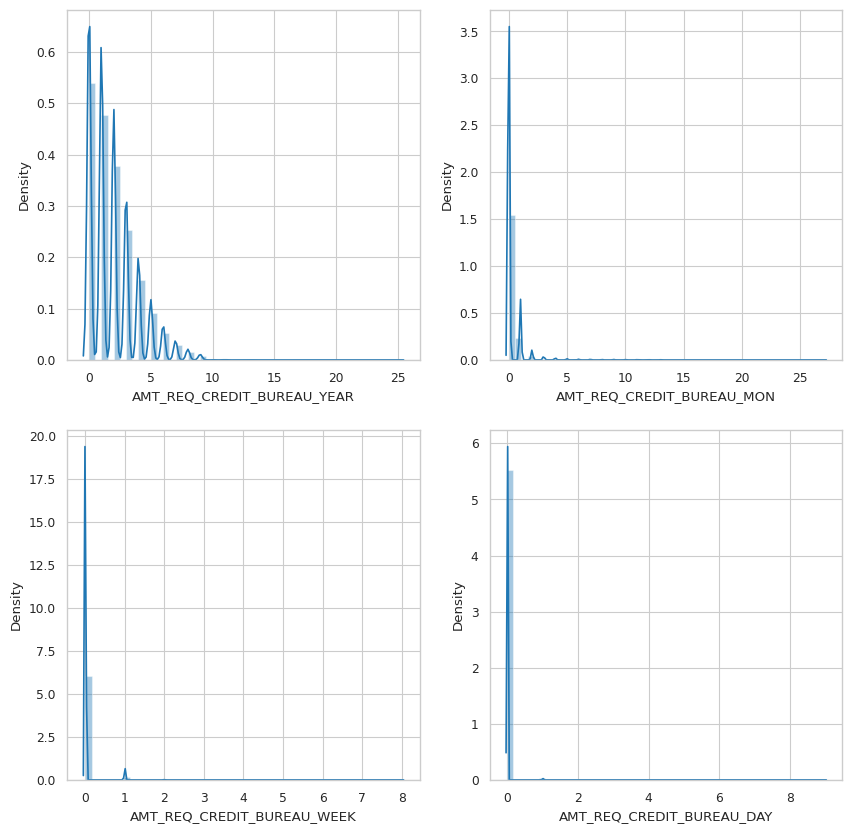

In [ ]:
#Distribution of numerical features that have missing values (1)
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_YEAR'], ax=ax[0][0])

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_MON'], ax=ax[0][1])

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_WEEK'], ax=ax[1][0])

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_DAY'], ax=ax[1][1])

<ipython-input-195-5e4520fff012>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_HOUR'], ax=ax[0][0])
<ipython-input-195-5e4520fff012>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_QRT'], ax=ax[0][1])
<ipython-input-195-5e4520ff

<Axes: xlabel='AMT_ANNUITY', ylabel='Density'>

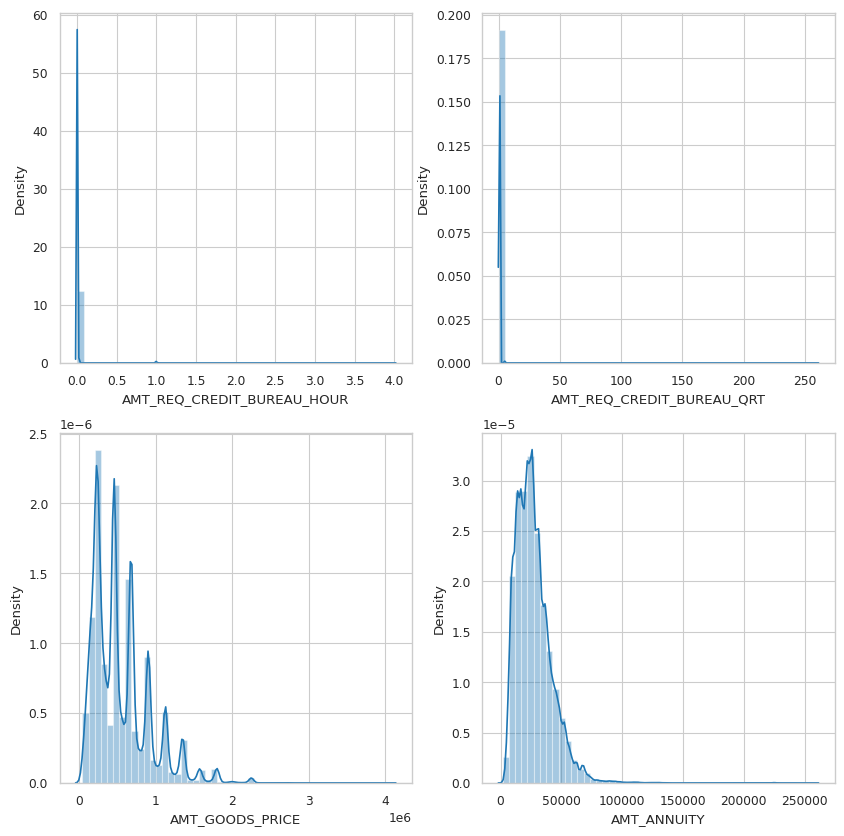

In [ ]:
#Distribution of numerical features that have missing values (2)
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_HOUR'], ax=ax[0][0])

sns.distplot(df_train['AMT_REQ_CREDIT_BUREAU_QRT'], ax=ax[0][1])

sns.distplot(df_train['AMT_GOODS_PRICE'], ax=ax[1][0])

sns.distplot(df_train['AMT_ANNUITY'], ax=ax[1][1])

<ipython-input-196-b14a8c5d8db6>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['DEF_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][0])
<ipython-input-196-b14a8c5d8db6>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][1])
<ipython-input-196-b14a8c5d8db

<Axes: xlabel='OBS_30_CNT_SOCIAL_CIRCLE', ylabel='Density'>

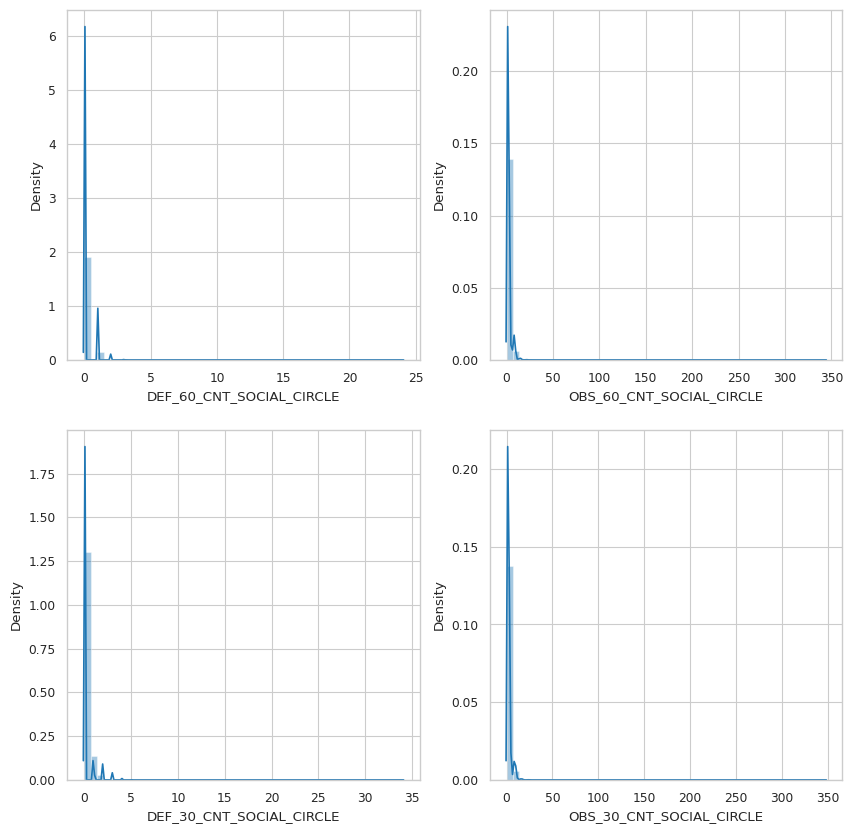

In [ ]:
#Distribution of numerical features that have missing values (3)
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df_train['DEF_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][0])

sns.distplot(df_train['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][1])

sns.distplot(df_train['DEF_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][0])

sns.distplot(df_train['OBS_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][1])

<ipython-input-197-7eebcfebd182>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['CNT_FAM_MEMBERS'], ax=ax[0])
<ipython-input-197-7eebcfebd182>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['DAYS_LAST_PHONE_CHANGE'], ax=ax[1])


<Axes: xlabel='DAYS_LAST_PHONE_CHANGE', ylabel='Density'>

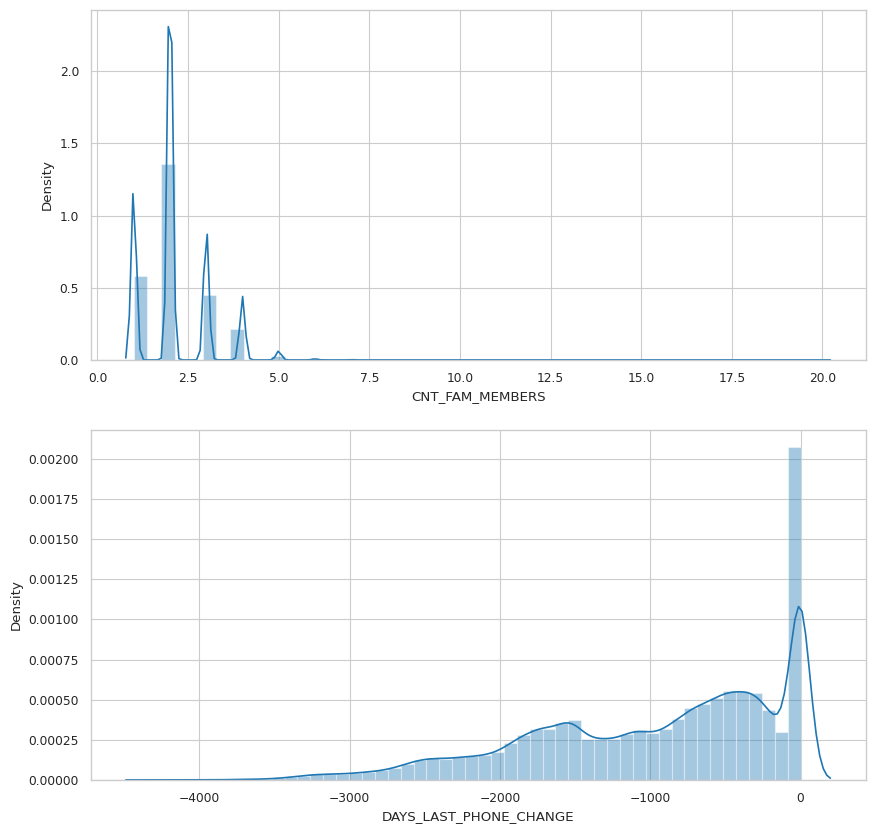

In [ ]:
#Distribution of numerical features that have missing values (4)
sns.set_style('whitegrid')
fig, ax = plt.subplots(2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df_train['CNT_FAM_MEMBERS'], ax=ax[0])

sns.distplot(df_train['DAYS_LAST_PHONE_CHANGE'], ax=ax[1])

It can be ssen that the distribution of numerical features that mentioned above is skewed, so the missing values in those features will be imputed with the median.

In [ ]:
#Impute missing values with median because the data is skewed for numerical features
#Impute missing values with mode for categorical features

category_columns = df_train.select_dtypes(include=['object']).columns.tolist()
integer_columns = df_train.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df_train:
    if df_train[column].isnull().any():
        if(column in category_columns):
            df_train[column]=df_train[column].fillna(df_train[column].mode()[0])
        else:
            df_train[column]=df_train[column].fillna(df_train[column].median())

print('Missing values status:', df_train.isnull().values.any())
print('\nThe number of missing values for each columns (after imputation): \n')
nvc = pd.DataFrame(df_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/df_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False

The number of missing values for each columns (after imputation): 



,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,REG_REGION_NOT_WORK_REGION,0,0.0
2,REGION_POPULATION_RELATIVE,0,0.0
3,AMT_INCOME_TOTAL,0,0.0
4,TARGET,0,0.0
...,...,...,...
68,FLAG_DOCUMENT_20,0,0.0
69,FLAG_DOCUMENT_21,0,0.0
70,AMT_REQ_CREDIT_BUREAU_HOUR,0,0.0
71,AMT_REQ_CREDIT_BUREAU_DAY,0,0.0


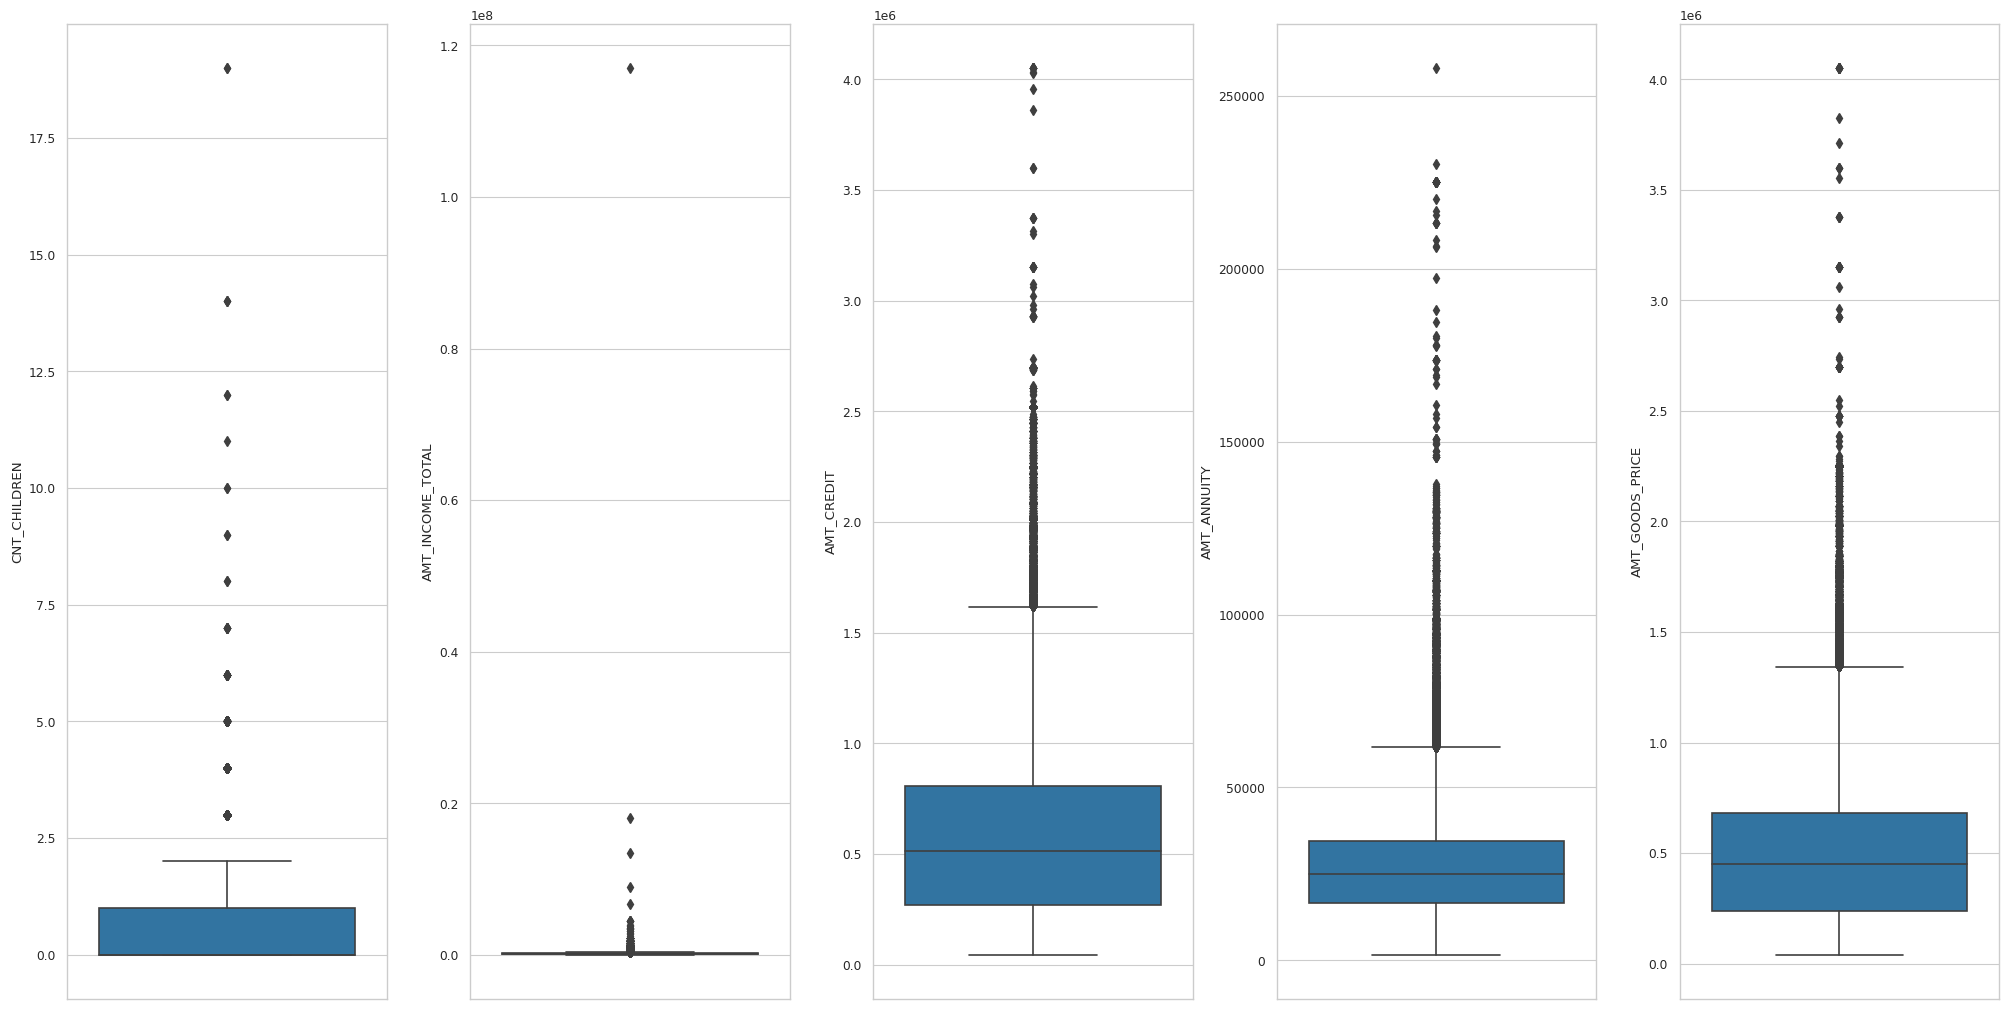

In [ ]:
#DETECTING OUTLIERS
#Dataset consist numerical feature (1)
int_features = df_train[["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

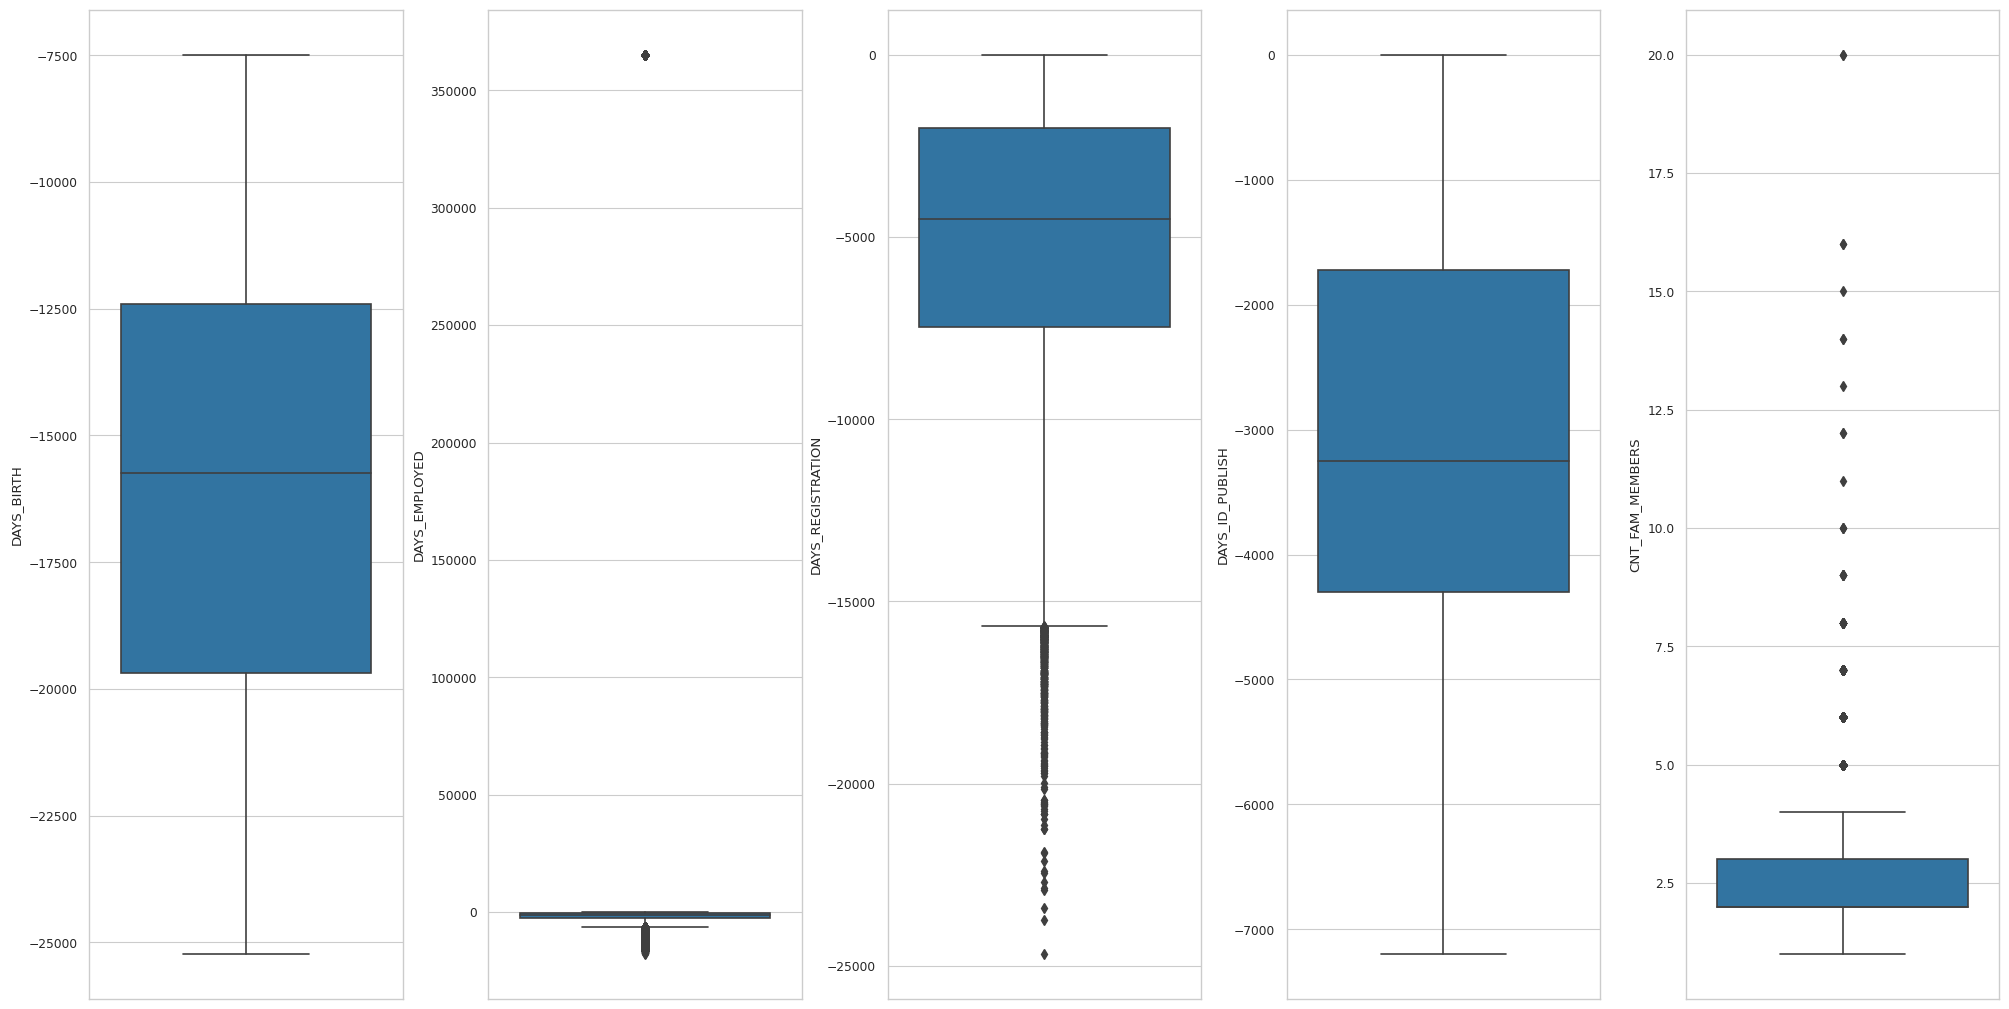

In [ ]:
#Dataset consist numerical feature (2)
int_features = df_train[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "CNT_FAM_MEMBERS"]]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

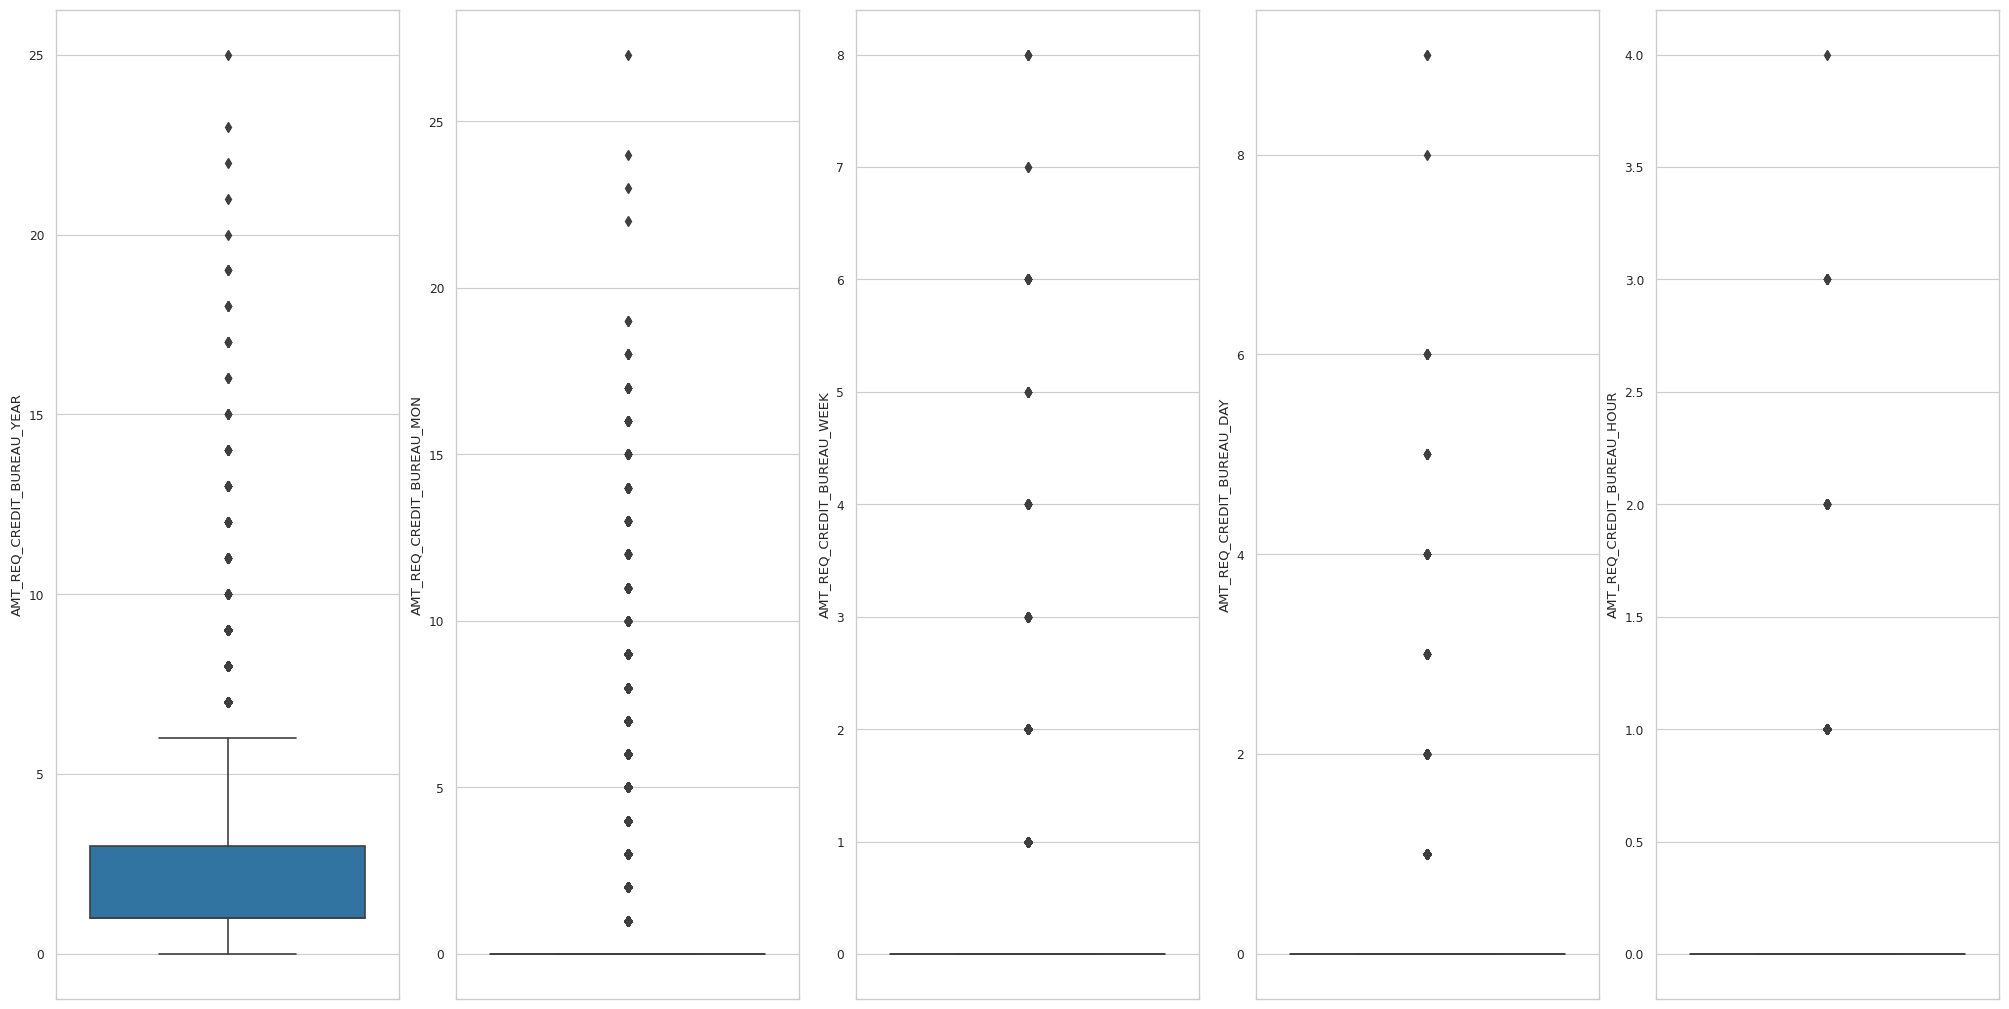

In [ ]:
#Dataset consist numerical feature (3)
int_features = df_train[["AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_HOUR"]]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

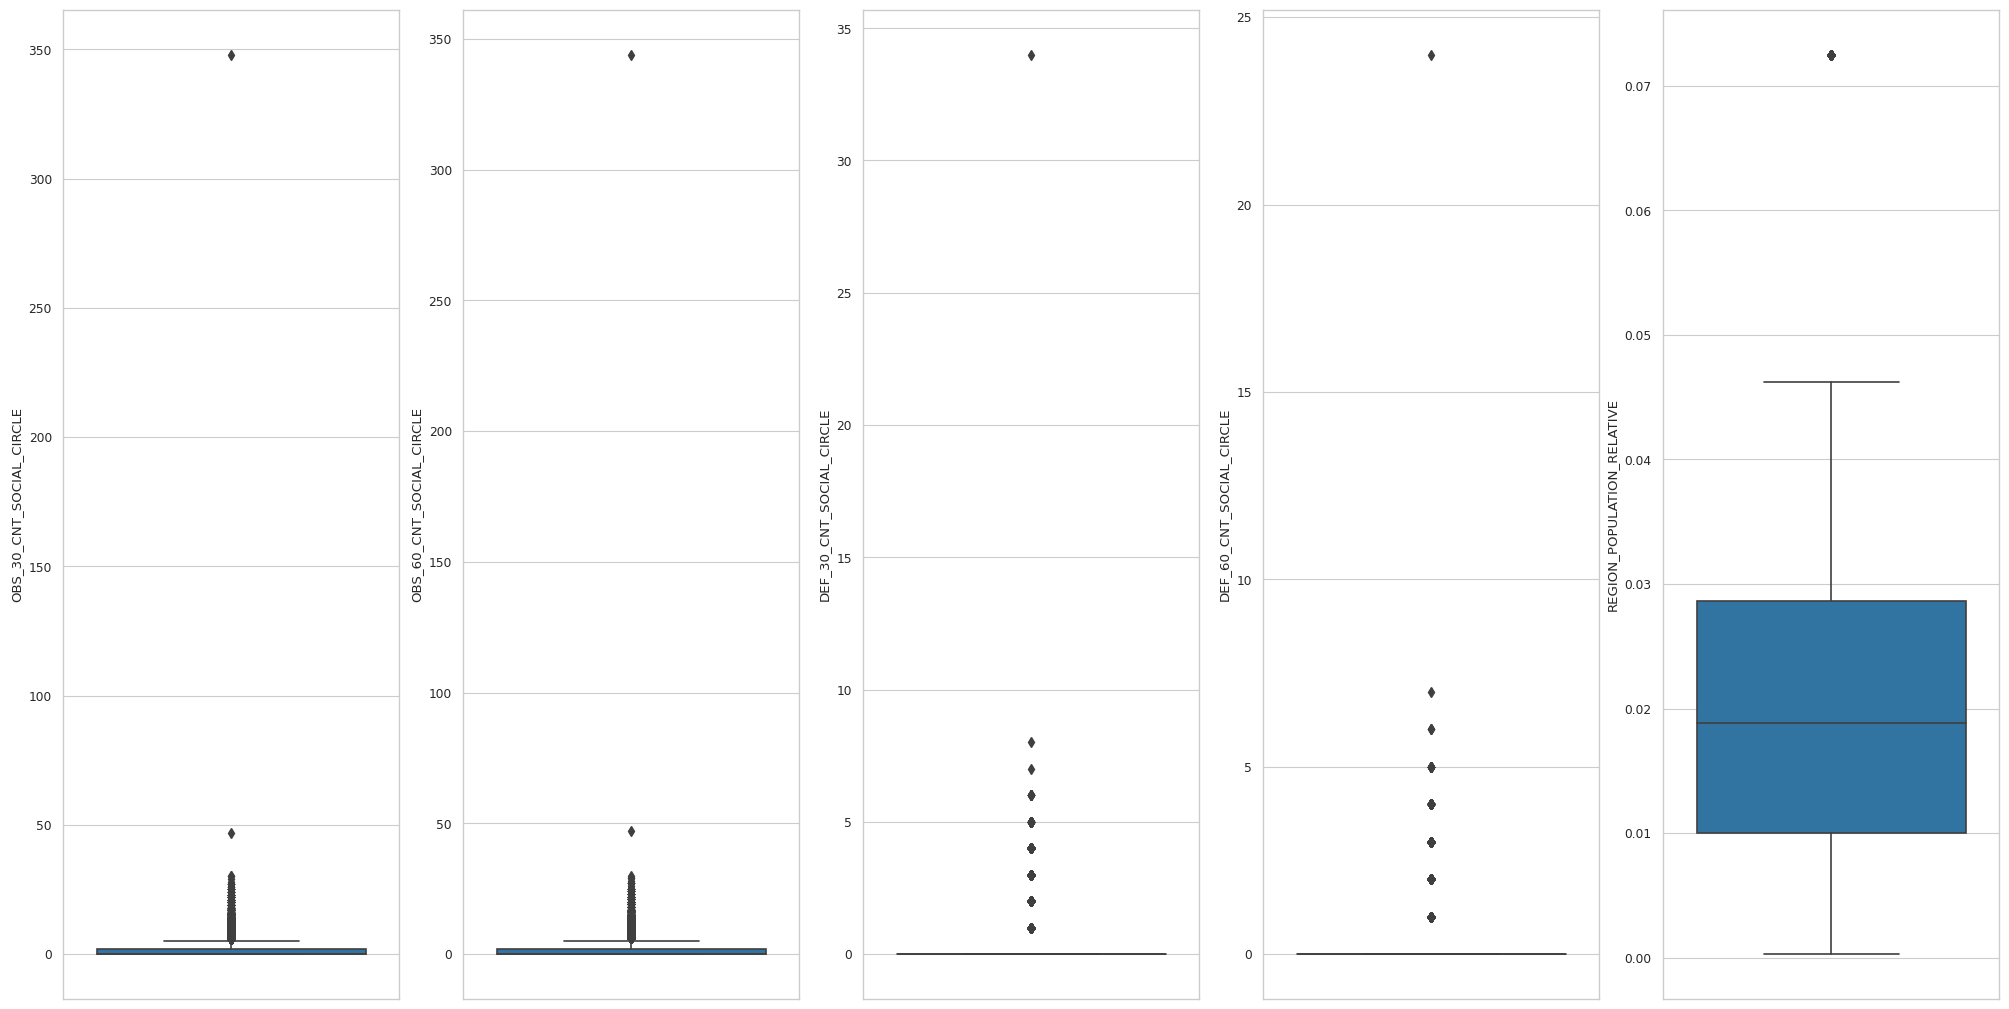

In [ ]:
#Dataset consist numerical feature (4)
int_features = df_train[["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "REGION_POPULATION_RELATIVE"]]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

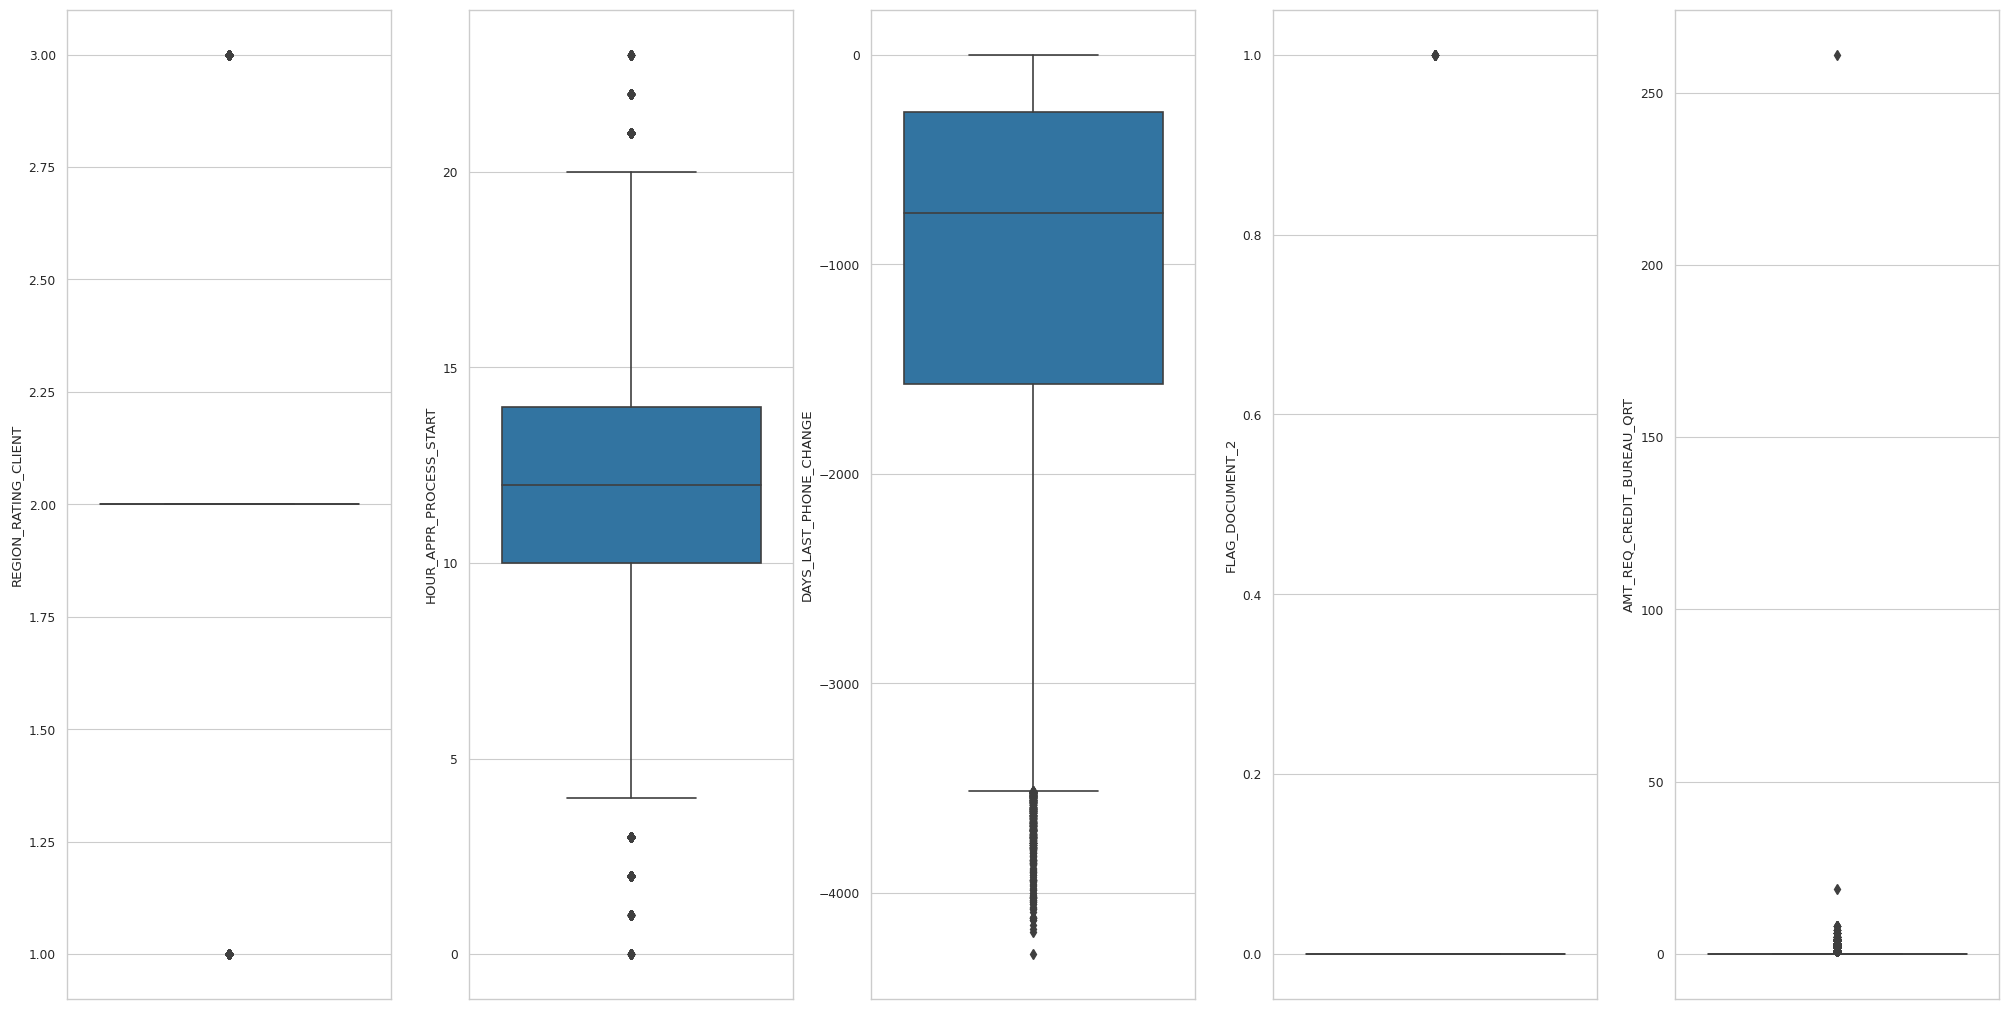

In [ ]:
#Dataset consist numerical feature (5)
int_features = df_train[["REGION_RATING_CLIENT", "HOUR_APPR_PROCESS_START", "DAYS_LAST_PHONE_CHANGE", "FLAG_DOCUMENT_2", "AMT_REQ_CREDIT_BUREAU_QRT"]]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Outliers on the numerical features mentioned above will not be removed because there may be insights that can be drawn from these outliers.

###**MACHINE LEARNING MODELS**

In [ ]:
#LABEL ENCODING
#Label encoder for object feature
df_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [ ]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#FEATURE SELECTION
#Drop Unnecessary Feature
df_train.drop(['SK_ID_CURR'], inplace=True, axis=1)

In [ ]:
df_train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#CONVERT NEGATIVE TO POSITIVE VALUES
#Negative valules are DAYS_BIRTH, DAYS_EMPLOYED, DAYS_ID_PUBLISH, DAYS_REGISTRATION, DAYS_LAST_PHONE_CHANGE
df_train.iloc[:,16:20] = df_train.iloc[:,16:20].abs()
df_train.iloc[:,45] = df_train.iloc[:,45].abs()

In [ ]:
#FEATURE SELECTION
x = df_train.drop(['TARGET'], axis=1)
y = df_train['TARGET']

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print('The features that correlate well with target feature:\n')
featureScores.sort_values(by=['Score'], ascending=False)

The features that correlate well with target feature:



,Features,Score
16,DAYS_EMPLOYED,1.954124e+08
8,AMT_GOODS_PRICE,1.223080e+08
6,AMT_CREDIT,7.669987e+07
15,DAYS_BIRTH,2.235391e+06
5,AMT_INCOME_TOTAL,1.624102e+06
...,...,...
48,FLAG_DOCUMENT_5,3.020010e-02
63,FLAG_DOCUMENT_20,1.425955e-02
65,AMT_REQ_CREDIT_BUREAU_HOUR,1.832008e-03
22,FLAG_CONT_MOBILE,7.863447e-05


It can be seen which features correlate well with payment difficulties.
1. **Best features:** DAYS_EMPLOYED, AMT_GOODS_PRICE, and AMT_CREDIT
2. **Worst features:** FLAG_MOBIL, FLAG_CONT_MOBILE, and AMT_REQ_CREDIT_BUREAU_HOUR

In [ ]:
#HANDLING DATA IMBALANCE
#Create two different dataframe of majority and minority class 
df_majority = df_train[(df_train['TARGET']==0)] 
df_minority = df_train[(df_train['TARGET']==1)] 

#Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 282686, # to match majority class
                                 random_state=42)  # reproducible results

#Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

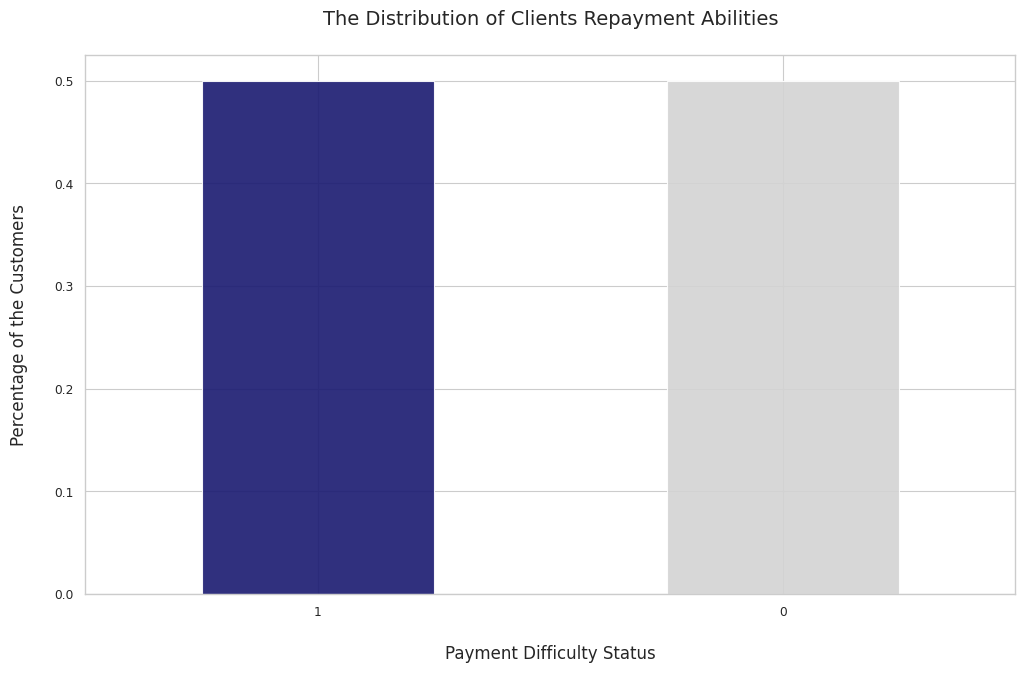

In [ ]:
fig = plt.figure(figsize = (12,7))
df_upsampled['TARGET'].value_counts(normalize=True).plot(kind='bar', color= ['midnightblue','lightgrey'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities\n', fontsize=14)
plt.ylabel('Percentage of the Customers\n', fontsize=12)
plt.xlabel('\nPayment Difficulty Status', fontsize=12)
plt.show()

It can be seen that the data is balanced, so the analysis can be continued.

####**DATA SPLITTING**

In [ ]:
#Define x and y features (top 20 features)
x_balanced = df_upsampled[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
y_balanced = df_upsampled['TARGET']

In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(452297, 20) (113075, 20)


In [ ]:
#Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

**MODEL BUILDING**
Here are some algorithms that will be tested to determine the best model:
1. Logistic Regression
2. Gaussian Naive Bayes
3. Decision Tree
4. Random Forest
5. K-Nearest Neighbor
6. Neural Network

**1. LOGISTIC REGRESSION**

In [ ]:
#Train the model
log_model = LogisticRegression().fit(X_train, y_train)
print(log_model)

LogisticRegression()


In [ ]:
#Predict data train
y_train_pred_log = log_model.predict(X_train)

#Print classification report
print('Classification Report Training Model (Logistic Regression):')
print(classification_report(y_train, y_train_pred_log))

Classification Report Training Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68    226185
           1       0.68      0.66      0.67    226112

    accuracy                           0.67    452297
   macro avg       0.67      0.67      0.67    452297
weighted avg       0.67      0.67      0.67    452297



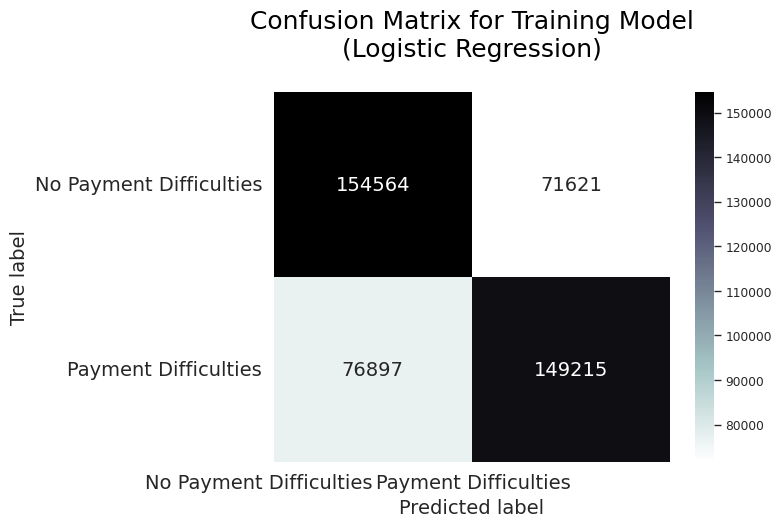

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_train, y_train_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
#Predict data test
y_test_pred_log = log_model.predict(X_test)

#Print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred_log))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     56501
           1       0.68      0.66      0.67     56574

    accuracy                           0.67    113075
   macro avg       0.67      0.67      0.67    113075
weighted avg       0.67      0.67      0.67    113075



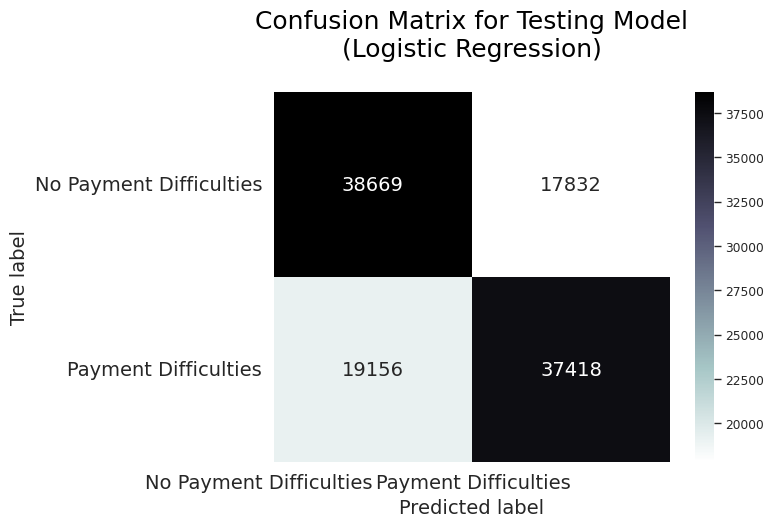

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_test, y_test_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_log_train=round(log_model.score(X_train,y_train)*100,2)
acc_log_test=round(log_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Test Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 67.16
Test Accuracy: % 67.29


It can be seen that:
*   Logistic regression model gives 67.16% correct results.
*   There is 0.13% error margin.

In [ ]:
#ROC scores
roc_auc_log = round(roc_auc_score(y_test, y_test_pred_log),4)
print('ROC AUC:', roc_auc_log)

ROC AUC: 0.6729


**2. GAUSSIAN NAIVE BAYES**

In [ ]:
#Train the model
gnb_model = GaussianNB().fit(X_train, y_train)
print(gnb_model)

GaussianNB()


In [ ]:
#Predict data train
y_train_pred_gnb = gnb_model.predict(X_train)

#Print classification report
print('Classification Report Training Model (Gaussian Naive Bayes):')
print(classification_report(y_train, y_train_pred_gnb))

Classification Report Training Model (Gaussian Naive Bayes):
              precision    recall  f1-score   support

           0       0.57      0.84      0.68    226185
           1       0.69      0.37      0.48    226112

    accuracy                           0.60    452297
   macro avg       0.63      0.60      0.58    452297
weighted avg       0.63      0.60      0.58    452297



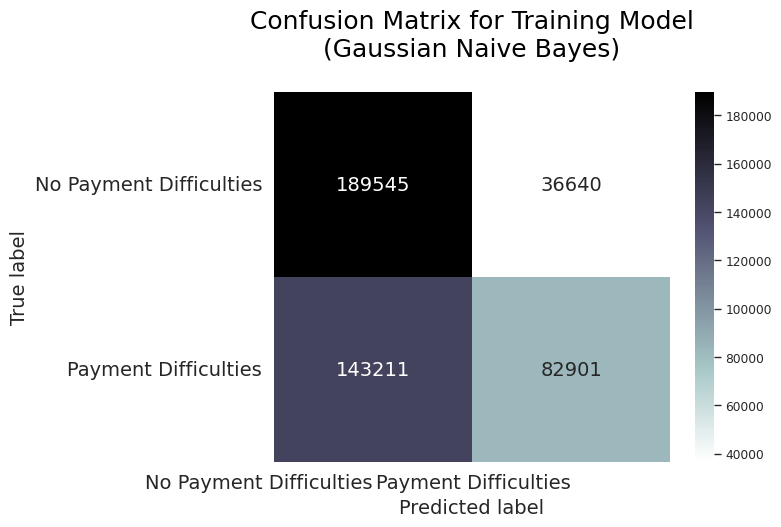

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_gnb = pd.DataFrame((confusion_matrix(y_train, y_train_pred_gnb)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_gnb, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Gaussian Naive Bayes)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
# predict data test
y_test_pred_gnb = gnb_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Gaussian Naive Bayes):')
print(classification_report(y_test, y_test_pred_gnb))

Classification Report Testing Model (Gaussian Naive Bayes):
              precision    recall  f1-score   support

           0       0.57      0.84      0.68     56501
           1       0.70      0.36      0.48     56574

    accuracy                           0.60    113075
   macro avg       0.63      0.60      0.58    113075
weighted avg       0.64      0.60      0.58    113075



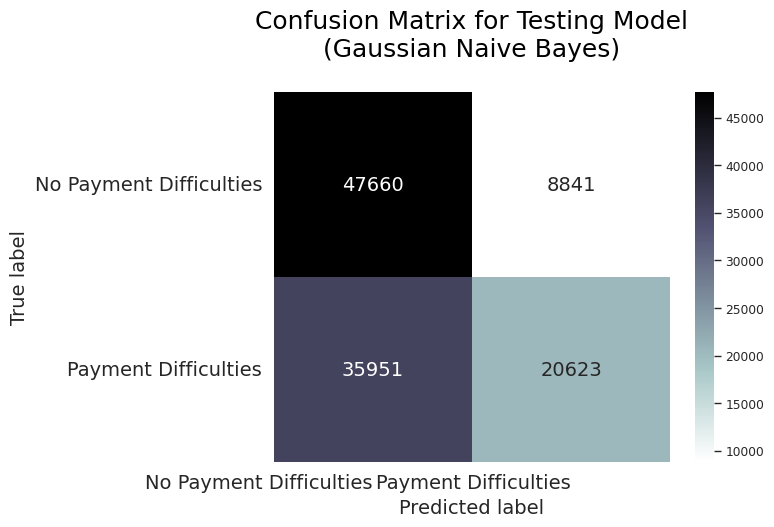

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_gnb = pd.DataFrame((confusion_matrix(y_test, y_test_pred_gnb)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_gnb, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Gaussian Naive Bayes)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_nb_train=round(gnb_model.score(X_train,y_train)*100,2)
acc_nb_test=round(gnb_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_nb_train))
print("Test Accuracy: % {}".format(acc_nb_test))

Training Accuracy: % 60.24
Test Accuracy: % 60.39


It can be seen that:
*   Gaussian naive bayes model gives 60.24% correct results.
*   There is 0.15% error margin.

In [ ]:
#ROC scores
roc_auc_gnb = round(roc_auc_score(y_test, y_test_pred_gnb),4)
print('ROC AUC:', roc_auc_gnb)

ROC AUC: 0.604


**3. DECISION TREE**

In [ ]:
#Train the model
dt_model = DecisionTreeClassifier().fit(X_train,y_train)
print(dt_model)

DecisionTreeClassifier()


In [ ]:
#Predict data train
y_train_pred_dt = dt_model.predict(X_train)

#Print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



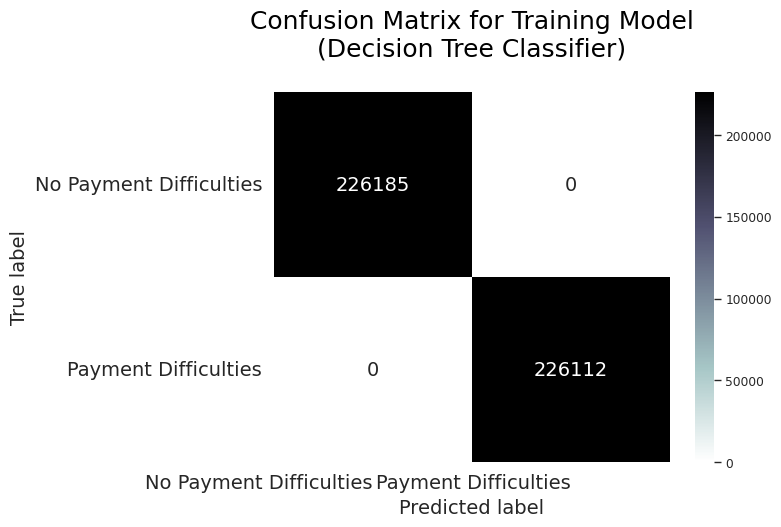

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
#Predict data test
y_test_pred_dt = dt_model.predict(X_test)

#Print classification report
print('Classification Report Testing Model (Decision Tree Classifier):')
print(classification_report(y_test, y_test_pred_dt))

Classification Report Testing Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     56501
           1       0.90      0.86      0.88     56574

    accuracy                           0.88    113075
   macro avg       0.88      0.88      0.88    113075
weighted avg       0.88      0.88      0.88    113075



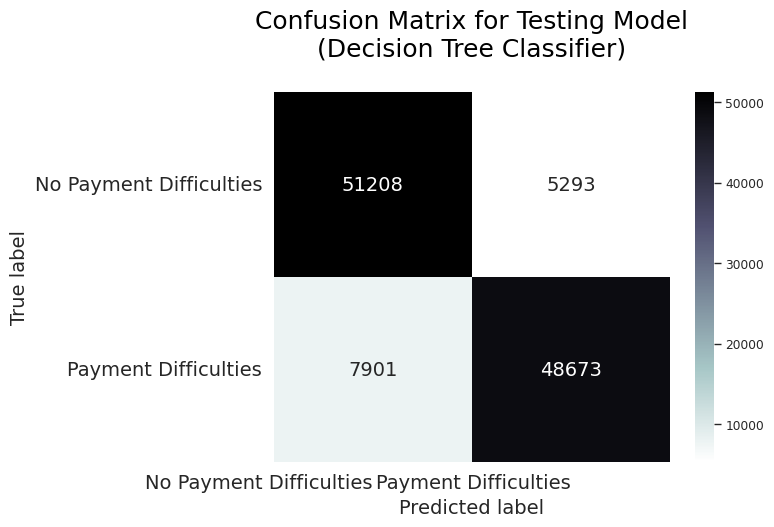

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_test, y_test_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_dt_train=round(dt_model.score(X_train,y_train)*100,2)
acc_dt_test=round(dt_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_dt_train))
print("Test Accuracy: % {}".format(acc_dt_test))

Training Accuracy: % 100.0
Test Accuracy: % 88.33


It can be seen that:
*   Decision tree gives 100% correct results.
*   There is 11.67% error margin.

In [ ]:
#ROC scores
roc_auc_dt = round(roc_auc_score(y_test, y_test_pred_dt),4)
print('ROC AUC:', roc_auc_dt)

ROC AUC: 0.8833


**4. RANDOM FOREST**

In [ ]:
#Train the model
rf_model = RandomForestClassifier().fit(X_train, y_train)
print(rf_model)

RandomForestClassifier()


In [ ]:
#Predict data train
y_train_pred_dt = rf_model.predict(X_train)

#Print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



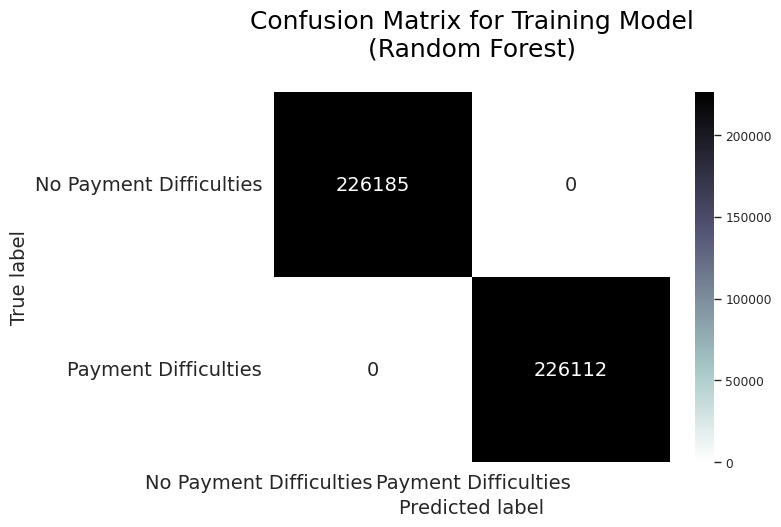

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
#Predict data test
y_test_pred_rf = rf_model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report

#Print classification report
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred_rf))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56501
           1       0.99      1.00      1.00     56574

    accuracy                           1.00    113075
   macro avg       1.00      1.00      1.00    113075
weighted avg       1.00      1.00      1.00    113075



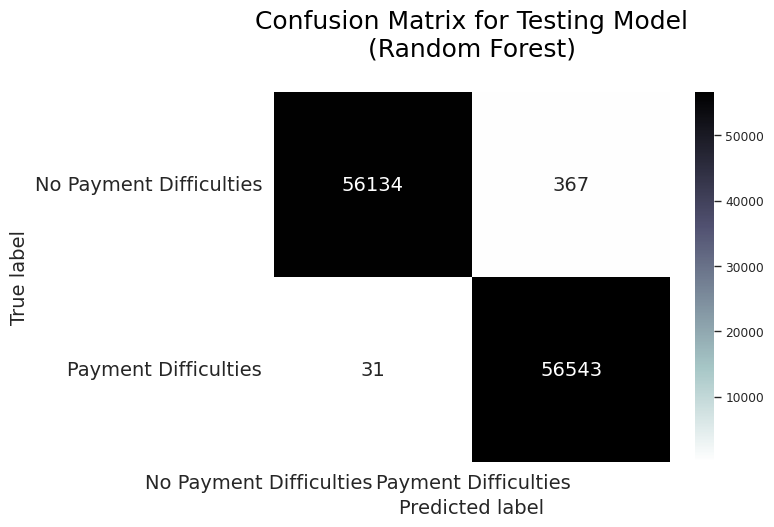

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_test, y_test_pred_rf)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_rf_train=round(rf_model.score(X_train,y_train)*100,2)
acc_rf_test=round(rf_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_rf_train))
print("Test Accuracy: % {}".format(acc_rf_test))

Training Accuracy: % 100.0
Test Accuracy: % 99.65


It can be seen that:
*   Random forest model gives 100% correct results.
*   There is 0.35% error margin.



In [ ]:
#ROC scores
roc_auc_rf = round(roc_auc_score(y_test, y_test_pred_rf),4)
print('ROC AUC:', roc_auc_rf)

ROC AUC: 0.9965


<ipython-input-243-8c67fb0fa78a>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


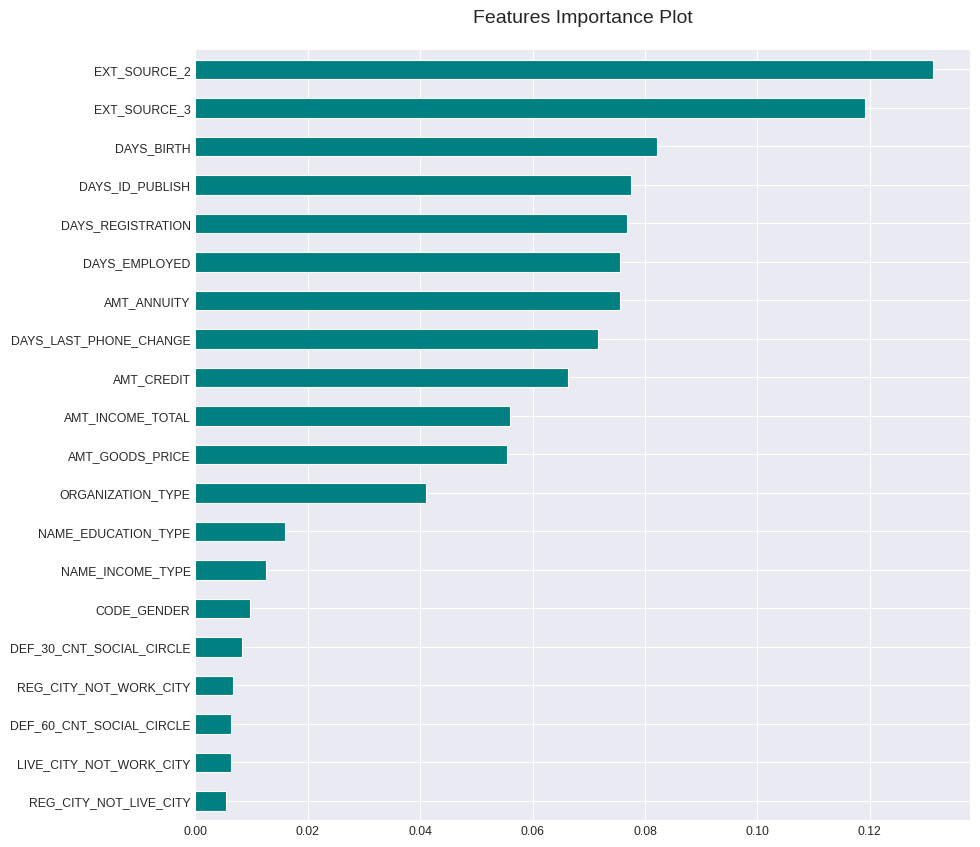

In [ ]:
#Important features
importances_rf = pd.Series(rf_model.feature_importances_, index=x_balanced.columns).sort_values(ascending=True)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,10))
fig = importances_rf.plot(kind ='barh', color ='teal')
plt.title('Features Importance Plot\n', fontsize=14)
plt.show()

fig.figure.tight_layout()
fig.figure.savefig('top feature.png')

The plot above confirms that the 5 most important features are EXT_SOURCE_2, EXT_SOURCE 3, DAYS_BIRTH, DAYS_ID_PUBLISH, and DAYS_REGISTRATION.

**5. K-NEAREST NEIGHBORS**

In [ ]:
#Train the model
knn_model = KNeighborsClassifier().fit(X_train,y_train)
print(knn_model)

KNeighborsClassifier()


In [ ]:
#Predit data train
y_train_pred_knn = knn_model.predict(X_train)

#Print classification report
print('Classification Report Training Model (K-Nearest Neighbors):')
print(classification_report(y_train, y_train_pred_knn))

Classification Report Training Model (K-Nearest Neighbors):
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    226185
           1       0.86      1.00      0.92    226112

    accuracy                           0.92    452297
   macro avg       0.93      0.92      0.92    452297
weighted avg       0.93      0.92      0.92    452297



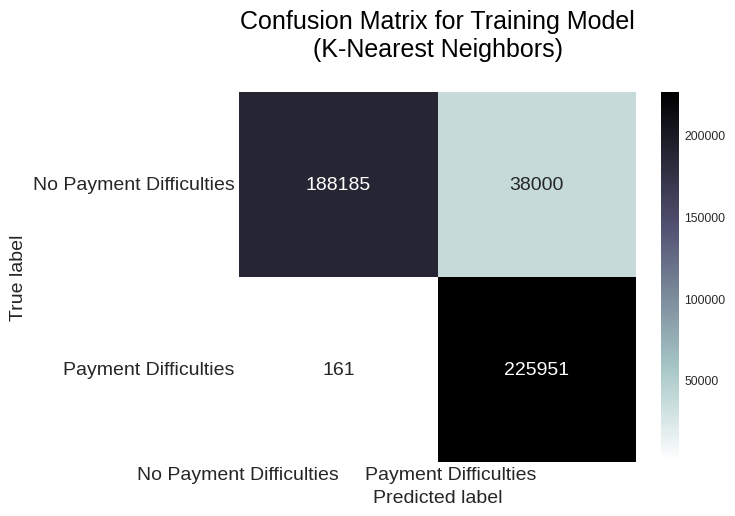

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_knn = pd.DataFrame((confusion_matrix(y_train, y_train_pred_knn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_knn, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(K-Nearest Neighbors)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
#Predit data test
y_test_pred_knn = knn_model.predict(X_test)

#Print classification report
print('Classification Report Testing Model (K-Nearest Neighbors):')
print(classification_report(y_test, y_test_pred_knn))

Classification Report Testing Model (K-Nearest Neighbors):
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     56501
           1       0.81      1.00      0.89     56574

    accuracy                           0.88    113075
   macro avg       0.90      0.88      0.88    113075
weighted avg       0.90      0.88      0.88    113075



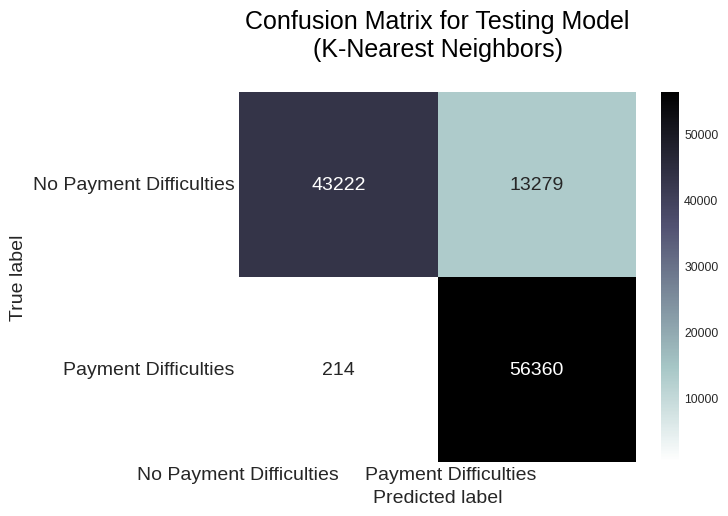

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_knn = pd.DataFrame((confusion_matrix(y_test, y_test_pred_knn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_knn, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(K-Nearest Neighbors)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_knn_train=round(knn_model.score(X_train,y_train)*100,2)
acc_knn_test=round(knn_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_knn_train))
print("Test Accuracy: % {}".format(acc_knn_test))

Training Accuracy: % 91.56
Test Accuracy: % 88.07


It can be seen that:
*   K-nearest neighbor model gives 91.56% correct results.
*   There is 3.49% error margin.

In [ ]:
#ROC scores
roc_auc_knn = round(roc_auc_score(y_test, y_test_pred_knn),4)
print('ROC AUC:', roc_auc_knn)

ROC AUC: 0.8806


**6. NEURAL NETWORK**

In [ ]:
#Train the model
nn_model = MLPClassifier().fit(X_train, y_train)

In [ ]:
#Predit data train
y_train_pred_nn = nn_model.predict(X_train)

#Print classification report
print('Classification Report Training Model (Neural Network):')
print(classification_report(y_train, y_train_pred_nn))

Classification Report Training Model (Neural Network):
              precision    recall  f1-score   support

           0       0.70      0.70      0.70    226185
           1       0.70      0.69      0.70    226112

    accuracy                           0.70    452297
   macro avg       0.70      0.70      0.70    452297
weighted avg       0.70      0.70      0.70    452297



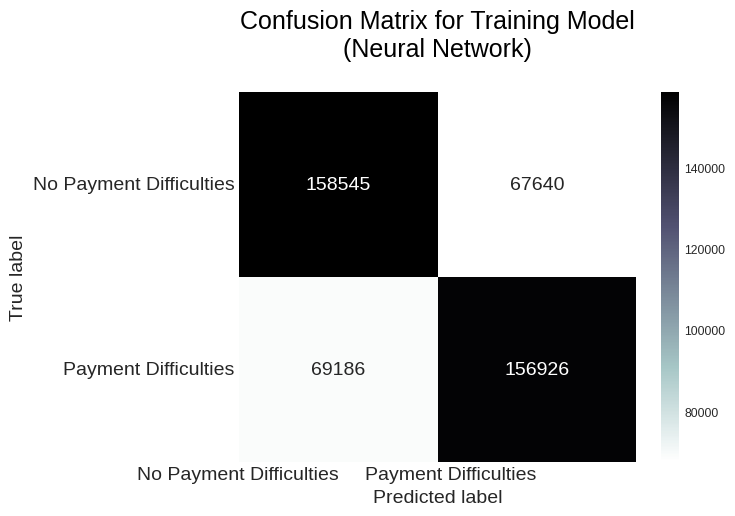

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_nn = pd.DataFrame((confusion_matrix(y_train, y_train_pred_nn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_nn, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Neural Network)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
#Predit data test
y_test_pred_nn = nn_model.predict(X_test)

#Print classification report
print('Classification Report Testing Model (Neural Network):')
print(classification_report(y_test, y_test_pred_nn))

Classification Report Testing Model (Neural Network):
              precision    recall  f1-score   support

           0       0.69      0.69      0.69     56501
           1       0.69      0.69      0.69     56574

    accuracy                           0.69    113075
   macro avg       0.69      0.69      0.69    113075
weighted avg       0.69      0.69      0.69    113075



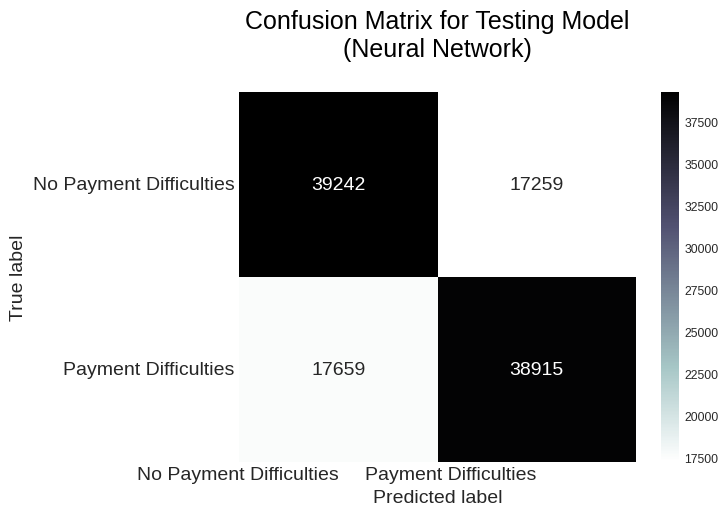

In [ ]:
#Form confusion matrix as a dataFrame
confusion_matrix_nn = pd.DataFrame((confusion_matrix(y_test, y_test_pred_nn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

#Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_nn, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Neural Network)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_nn_train=round(nn_model.score(X_train,y_train)*100,2)
acc_nn_test=round(nn_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_nn_train))
print("Test Accuracy: % {}".format(acc_nn_test))

Training Accuracy: % 69.75
Test Accuracy: % 69.12


It can be seen that:
*   Neural network model gives 69.75% correct results.
*   There is 0.63% error margin.

In [ ]:
#ROC scores
roc_auc_nn = round(roc_auc_score(y_test, y_test_pred_nn),4)
print('ROC AUC:', roc_auc_nn)

ROC AUC: 0.6912


In [ ]:
#MODEL SELECTION
results = pd.DataFrame([["Logistic Regression", 0.6716, 0.6729, 0.6729],["Gaussian Naive Bayes", 0.6024, 0.6039, 0.604],
                       ["Decision Tree", 1, 0.8826, 0.8826],["Random Forest", 1, 0.9965, 0.9965],
                       ["K-Nearest Neighbor", 0.9156, 0.8807, 0.8806], ["Neural Network", 0.7001, 0.6948, 0.6948]],
                        columns = ["Models", "Training Accuracy Score", "Testing Accuracy Score", "ROC Score"])

results.sort_values(by=['Training Accuracy Score', 'Testing Accuracy Score'], ascending=False).style.background_gradient(cmap='Blues')

,Models,Training Accuracy Score,Testing Accuracy Score,ROC Score
3,Random Forest,1.000000,0.996500,0.996500
2,Decision Tree,1.000000,0.882600,0.882600
4,K-Nearest Neighbor,0.915600,0.880700,0.880600
5,Neural Network,0.700100,0.694800,0.694800
0,Logistic Regression,0.671600,0.672900,0.672900
1,Gaussian Naive Bayes,0.602400,0.603900,0.604000


The prediction accuracy of the train and test data in **Random Forest** model has a value that is not much different, it can be said that the model is very good, which is there is **no underfitting** or **overfitting**. So the Random Forest model was chosen as the **best model to predict client's repayment abilities**.

###**PREDICTION**

In [ ]:
df_test = pd.read_csv("application_test.csv", sep=',')
print('This dataset has %d rows dan %d columns.\n' % df_test.shape)
df_test.head()

This dataset has 48744 rows dan 121 columns.



,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


There are total 48.744 rows which contains the information of loans and there are 121 features without target feature.

####**DATA PREPROCESSING**

In [ ]:
#DETECTING DUPLICATION
print('The number of duplication is:', df_test.duplicated().sum())

The number of duplication is: 0


In [ ]:
#DETECTING MISSING  VALUES
#check for empty elements
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,COMMONAREA_AVG,33495,68.716150
1,COMMONAREA_MODE,33495,68.716150
2,COMMONAREA_MEDI,33495,68.716150
3,NONLIVINGAPARTMENTS_AVG,33347,68.412523
4,NONLIVINGAPARTMENTS_MODE,33347,68.412523
...,...,...,...
116,NAME_HOUSING_TYPE,0,0.000000
117,NAME_FAMILY_STATUS,0,0.000000
118,NAME_EDUCATION_TYPE,0,0.000000
119,NAME_INCOME_TYPE,0,0.000000


In [ ]:
#Drop features that have large number of missing values (± 50%)
df_test.drop(df_test.iloc[:, 43:90], inplace=True, axis=1)
df_test.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [ ]:
#After drop some features
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,15605,32.014197
1,EXT_SOURCE_3,8668,17.782701
2,AMT_REQ_CREDIT_BUREAU_YEAR,6049,12.409732
3,AMT_REQ_CREDIT_BUREAU_QRT,6049,12.409732
4,AMT_REQ_CREDIT_BUREAU_MON,6049,12.409732
...,...,...,...
67,REG_REGION_NOT_LIVE_REGION,0,0.000000
68,REG_REGION_NOT_WORK_REGION,0,0.000000
69,LIVE_REGION_NOT_WORK_REGION,0,0.000000
70,REG_CITY_NOT_LIVE_CITY,0,0.000000


In [ ]:
#Impute missing values with median because the data is skewed for numerical features
#Impute missing values with mode for categorical features

category_columns = df_test.select_dtypes(include=['object']).columns.tolist()
integer_columns = df_test.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df_test:
    if df_test[column].isnull().any():
        if(column in category_columns):
            df_test[column]=df_test[column].fillna(df_test[column].mode()[0])
        else:
            df_test[column]=df_test[column].fillna(df_test[column].median())

In [ ]:
#After imputation
print('Missing values status:', df_test.isnull().values.any())
tvc = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tvc['Percentage'] = (tvc['Total Null Values']/df_test.shape[0])*100
tvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False


,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,NAME_CONTRACT_TYPE,0,0.0
2,FLAG_DOCUMENT_8,0,0.0
3,FLAG_DOCUMENT_7,0,0.0
4,FLAG_DOCUMENT_6,0,0.0
...,...,...,...
67,FLAG_CONT_MOBILE,0,0.0
68,FLAG_WORK_PHONE,0,0.0
69,FLAG_EMP_PHONE,0,0.0
70,FLAG_MOBIL,0,0.0


In [ ]:
#LABEL ENCODING
#Label encoder for object features
df_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df_test[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [ ]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [ ]:
#CONVERT NEGATIVE VALUES TO POSITIVE VALUES
df_test.iloc[:,16:20] = df_test.iloc[:,16:20].abs()
df_test.iloc[:,45] = df_test.iloc[:,45].abs()

**PREDICTION**

Predict client's repayment abilities on application data test with the best machine learning  model obtained before, i.e **Random Forest**.

In [ ]:
pred_test = df_test[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
pred_test.head()

,DAYS_EMPLOYED,AMT_GOODS_PRICE,AMT_CREDIT,DAYS_BIRTH,AMT_INCOME_TOTAL,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,AMT_ANNUITY,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,CODE_GENDER,EXT_SOURCE_2,REG_CITY_NOT_LIVE_CITY,NAME_EDUCATION_TYPE,DEF_30_CNT_SOCIAL_CIRCLE,EXT_SOURCE_3,DEF_60_CNT_SOCIAL_CIRCLE,LIVE_CITY_NOT_WORK_CITY
0,2329,450000.0,568800.0,19241,135000.0,5170.0,1740.0,812,20560.5,28,6,0,0,0.789654,0,1,0.0,0.159520,0.0,0
1,4469,180000.0,222768.0,18064,99000.0,9118.0,0.0,1623,17370.0,42,6,0,1,0.291656,0,4,0.0,0.432962,0.0,0
2,4458,630000.0,663264.0,20038,202500.0,2175.0,856.0,3503,69777.0,54,6,0,1,0.699787,0,1,0.0,0.610991,0.0,0
3,1866,1575000.0,1575000.0,13976,315000.0,2000.0,1805.0,4208,49018.5,5,6,0,0,0.509677,0,4,0.0,0.612704,0.0,0
4,2191,625500.0,625500.0,13040,180000.0,4000.0,821.0,4262,32067.0,5,6,1,1,0.425687,0,4,0.0,0.519097,0.0,1


In [ ]:
#Lets predict!
predict = pd.Series(rf_model.predict(pred_test), name = "TARGET").astype(int)
results = pd.concat([df_test['SK_ID_CURR'], predict],axis = 1)
results.to_csv("predict application.csv", index = False)
results.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


###**RECOMMENDATION**

Based on data, **students, accountant, high skill tech staff** and **manager** are capable to repaying the loans. But there are only a few applications that come from them. So, here is the recommendation for the company:

*   Make some promotional activities to attract more of them to apply for a loan.
*   Otherwise, **maternity leaves, cash loan,** and **unemployed** clients who is incapable of repaying the loan (50-100% application rejected) need to do a survey so that the company can recommend the right contract type in the future and their applications will be approved.



